# 프로젝트: KoChatGPT 업그레이드 하기

1. 우리가 지난시간 살펴본 KoChatGPT 모델에 사용한 데이터셋은 아직 완벽히 정제되지 않았습니다.

2. Hunman Feedback이 반영된 데이터셋을 대체하기 위해 SFT와 RM 모델에 사용할 다양한 benchmark 데이터셋도 검토해볼 수 있습니다.

3. 언어모델의 생성능력을 좌우하는 최선의 디코딩을 위한 하이퍼파라미터 서치가 필요합니다.

4. 생성된 답변에 대한 주관적인 평가를 보완할 수 있는 정량적인 메트릭은 도입하지 않았었습니다.

5. LLM Trend Note1에서 살펴본 다양한 Instruction Tuning 및 Prompting 기법들도 적용해볼만 합니다.

6. 무엇보다 foundation model로 사용한 KoGPT-2는 Emergent abilities를 기대하기엔 다소 작은 사이즈의 모델입니다. 더 큰 파라미터 스케일을 가진 모델을 사용해보거나,

7. 더 효율적인 연산을 수행할 수 있는 LoRA의 적용 또는 새로운 Instruction Tuning 및 reward ranking 알고리즘을 도입해볼 수도 있습니다.

In [10]:
# 파일 저장 커스텀 모듈

import sys
sys.path.append("../custom")

from importlib import reload
import custom_utils
reload(custom_utils)

from custom_utils import save_var, load_var

In [11]:
import torch
import gc
# Check for and set up GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def get_cuda_memory_summary():
    # Obtain and print GPU memory summary
    memory_summary = torch.cuda.memory_summary(device=device, abbreviated=False)
    print(memory_summary)
    
def empty_cuda_cache():
    # Run your deep learning code on the GPU
    gc.collect()
    torch.cuda.empty_cache()
    torch.cuda.synchronize()

In [15]:
del model
del tokenizer
del trainer

In [36]:
empty_cuda_cache()
get_cuda_memory_summary()

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 1            |        cudaMalloc retries: 2         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |   13501 MB |   13557 MB |   23851 MB |   10350 MB |
|       from large pool |   13473 MB |   13529 MB |   23177 MB |    9704 MB |
|       from small pool |      28 MB |     176 MB |     674 MB |     645 MB |
|---------------------------------------------------------------------------|
| Active memory         |   13501 MB |   13557 MB |   23851 MB |   10350 MB |
|       from large pool |   13473 MB |   13529 MB |   23177 MB |

# 기존 데이터셋 추가 정제

```
data_kochatgpt 폴더에는 세 파일이 있습니다.
ㄱ. kochatgpt_1_SFT.jsonl : SFT를 위한 prompt와 completion 문장셋
ㄴ. kochatgpt_1_RM.jsonl : RM 학습을 위한 prompt와 세 가지 ranking 문장셋
ㄷ. kochatgpt_1_PPO.jsonl : promt 문장

각 말뭉치를 EDA하여 도메인과 문체, 길이분포, 문장의 완성도 등을 분석합니다.
언어모델의 문장생성능력은 말뭉치의 전처리 수준에 큰 영향을 받습니다.
말뭉치의 분석결과를 토대로 데이터를 정제하여 모델을 재학습시켜봅니다.
(정제후 데이터셋 크기가 줄어들지 않도록, 다양한 augmentation 기법을 활용하여 크기를 유지 내지 증량합니다.)
추가 전처리 후, 기존 인퍼런스 결과와 성능을 비교해봅니다.
(주관적인 평가와 BLEU, ROUGE 등을 활용한 정량적인 평가 결과를 비교 분석하여 제시합니다.)
```

In [55]:
import json 

def get_json_dataset(data):
    with open(data, "r", encoding='utf-8-sig') as json_file:
        dataset = json.load(json_file)
    return dataset

In [1]:
import json 

data_sft = 'KoChatGPT/data_kochatgpt/kochatgpt_1_SFT.jsonl' 
with open(data_sft, "r", encoding='utf-8-sig') as json_file:
    list_data_dict = json.load(json_file)

In [153]:
list_data_dict[0:2]

[{'prompt': '불고기용 고기 한우에요?',
  'completion': "'저는 인공지능 챗봇이며, 직접적으로 식품에 관한 정보를 가지고 있지 않습니다. 하지만 일반적으로 불고기용 고기는 한우, 쇠고기, 돼지고기 등 다양한 종류의 고기를 사용합니다. 하지만 한우는 대표적인 고급 육류로 알려져 있기 때문에, 한우를 사용하는 경우도 많습니다. 알러지나 개별 건강 상태에 따라 다를 수 있으니 충분한 정보 수집 후에 선택해 주시기 바랍니다.",
  'tokens': 193},
 {'prompt': '쓰던 앱이 유료로 전환됐어',
  'completion': "'어떤 앱인지 모르기 때문에 정확한 답변을 드리기 어렵습니다. 하지만, 일반적으로 유료 전환된 앱은 기존 무료 앱에서 추가적인 기능이나 서비스를 제공하는 경우가 많습니다. 이 경우, 유료 전환 이전 가격이 매우 저렴하거나 무료인 경우가 많으므로, 앱을 계속 사용하려면 추가적인 비용을 지불해야 할 수 있습니다. 하지만, 유료 전환 이후에는 기존 사용자 또는 새로운 사용자 모두가 추가 기능과 높은 품질의 서비스를 이용할 수 있게 됩니다. 따라서, 앱 개발자는 유료 모델로 전환함으로써 앱의 수익을 증가시키고 더 나은 서비스를 제공할 수 있습니다.",
  'tokens': 288}]

In [160]:
import json 

path_tmp = 'data/kochatgpt_1_sft_aug.jsonl' 
with open(path_tmp, "r", encoding='utf-8-sig') as json_file:
    tmp = json.load(json_file)

In [161]:
tmp[0]

{'prompt': '불고기용 고기 한우에요?',
 'completion': "'저는 인공지능 챗봇이며, 직접적으로 식품에 관한 정보를 가지고 있지 않습니다. 하지만 일반적으로 불고기용 고기는 한우, 쇠고기, 돼지고기 등 다양한 종류의 고기를 사용합니다. 하지만 한우는 대표적인 고급 육류로 알려져 있기 때문에, 한우를 사용하는 경우도 많습니다. 알러지나 개별 건강 상태에 따라 다를 수 있으니 충분한 정보 수집 후에 선택해 주시기 바랍니다."}

In [145]:
import pandas as pd

df = pd.DataFrame(list_data_dict)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   prompt      12000 non-null  object
 1   completion  12000 non-null  object
 2   tokens      12000 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 281.4+ KB


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


<AxesSubplot:>

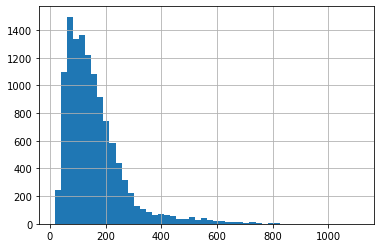

In [28]:
df["tokens"].hist(bins=50)

In [65]:
df_underlen = df[df["tokens"] < 300]

<AxesSubplot:>

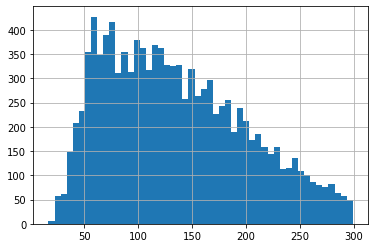

In [67]:
df_underlen["tokens"].hist(bins=50)

In [69]:
df_underlen.shape[0]

11054

In [109]:
df_underlen[df_underlen['completion'].isna() == True]

,prompt,completion,tokens


## tokenize

In [6]:
from konlpy.tag import Mecab

mecab = Mecab()

In [7]:
path_stopwords = 'data/stopword.txt'

stopwords = []
with open(path_stopwords, 'r') as file:
    for line in file:
        stopwords.append(line.strip())

In [71]:
def tokenize_text(text, tokenizer, stopwords):
    text = tokenizer.morphs(text) # 토큰화
#     text = [word for word in text if word not in stopwords] # 불용어 제거
    return text

## Augmentation

In [60]:
model_path = 'data/ko.bin'

In [61]:
from gensim.models import FastText

fasttext_model = FastText.load_fasttext_format(model_path)

/tmp/ipykernel_362/1204155077.py:4: DeprecationWarning: Call to deprecated `load_fasttext_format` (use load_facebook_vectors (to use pretrained embeddings) or load_facebook_model (to continue training with the loaded full model, more RAM) instead).
  fasttext_model = FastText.load_fasttext_format(model_path)


In [63]:
similar_words = fasttext_model.wv.most_similar('대표', topn=10)

In [116]:
import random

def lexical_sub(sentence, wv, tokenizer, sentence_num=2, verbose=False):
    if len(sentence) == 0: return None
    if verbose: print(f"lexical_sub: sentence={sentence}")
        
    sentences = []
    text = tokenizer.morphs(sentence)
    for _ in range(sentence_num):
        sentences.append(text)
    
    if not sentences[0]: return None
    
    indices = list(range(len(text)))
    random.shuffle(indices)    
    unique_indices = indices[:sentence_num]

    if verbose: print("lexical_sub: similar_words=", end="")
    for i, index in enumerate(unique_indices):
        word = sentences[i][index]
        if word in wv:
            similar_word = wv.most_similar(word)
            if not similar_word:
                return None
            if verbose: print(similar_word[0][0], end=", ")

            word_sub = similar_word[0][0]
            sentences[i][index] = word_sub
            sentences[i] = " ".join(sentences[i])
            
    if verbose: 
        print()
        print(f"lexical_sub: sentences={sentences}")
        
    return sentences

In [91]:
res = lexical_sub(df_underlen['prompt'].iloc[0], fasttext_model.wv, mecab, verbose=True)
res

불고기용 고기 한우에요?
닭고기, 전용, 

['닭고기 용 고기 한우 에 요 ?', '불고기 전용 고기 한우 에 요 ?']

In [93]:
from tqdm.notebook import tqdm

In [94]:
questions = df_underlen['prompt']
answers = df_underlen['completion']

In [ ]:
corpus_aug = []
count_none = 0

for que, ans in tqdm(zip(questions, answers), total=len(questions)):
    corpus_aug.append((que, ans))
    sentences = lexical_sub(que, fasttext_model.wv, mecab, sentence_num=1)
    if sentences != None:
        for sentence in sentences:
            if sentence is not None:
                corpus_aug.append((sentence, ans))

In [122]:
len(corpus_aug)

22105

In [121]:
for index, item in enumerate(corpus_aug):
    print(f"{index:2} {item}")
    if index >= 3: break

 0 ('불고기용 고기 한우에요?', "'저는 인공지능 챗봇이며, 직접적으로 식품에 관한 정보를 가지고 있지 않습니다. 하지만 일반적으로 불고기용 고기는 한우, 쇠고기, 돼지고기 등 다양한 종류의 고기를 사용합니다. 하지만 한우는 대표적인 고급 육류로 알려져 있기 때문에, 한우를 사용하는 경우도 많습니다. 알러지나 개별 건강 상태에 따라 다를 수 있으니 충분한 정보 수집 후에 선택해 주시기 바랍니다.")
 1 ('불고기 용 고기 축산업 에 요 ?', "'저는 인공지능 챗봇이며, 직접적으로 식품에 관한 정보를 가지고 있지 않습니다. 하지만 일반적으로 불고기용 고기는 한우, 쇠고기, 돼지고기 등 다양한 종류의 고기를 사용합니다. 하지만 한우는 대표적인 고급 육류로 알려져 있기 때문에, 한우를 사용하는 경우도 많습니다. 알러지나 개별 건강 상태에 따라 다를 수 있으니 충분한 정보 수집 후에 선택해 주시기 바랍니다.")
 2 ('쓰던 앱이 유료로 전환됐어', "'어떤 앱인지 모르기 때문에 정확한 답변을 드리기 어렵습니다. 하지만, 일반적으로 유료 전환된 앱은 기존 무료 앱에서 추가적인 기능이나 서비스를 제공하는 경우가 많습니다. 이 경우, 유료 전환 이전 가격이 매우 저렴하거나 무료인 경우가 많으므로, 앱을 계속 사용하려면 추가적인 비용을 지불해야 할 수 있습니다. 하지만, 유료 전환 이후에는 기존 사용자 또는 새로운 사용자 모두가 추가 기능과 높은 품질의 서비스를 이용할 수 있게 됩니다. 따라서, 앱 개발자는 유료 모델로 전환함으로써 앱의 수익을 증가시키고 더 나은 서비스를 제공할 수 있습니다.")
 3 ('쓰 던 앱 은 유료 로 전환 됐 어', "'어떤 앱인지 모르기 때문에 정확한 답변을 드리기 어렵습니다. 하지만, 일반적으로 유료 전환된 앱은 기존 무료 앱에서 추가적인 기능이나 서비스를 제공하는 경우가 많습니다. 이 경우, 유료 전환 이전 가격이 매우 저렴하거나 무료인 경우가 많으므로, 앱을 계속 사용하려면 추가적인 비용을 지불해야 할 수 있습니다. 하지만, 유

In [123]:
df_aug = pd.DataFrame(corpus_aug, columns=["prompt", "completion"])

In [124]:
df_aug.head(3)

,prompt,completion
0,불고기용 고기 한우에요?,"'저는 인공지능 챗봇이며, 직접적으로 식품에 관한 정보를 가지고 있지 않습니다. 하..."
1,불고기 용 고기 축산업 에 요 ?,"'저는 인공지능 챗봇이며, 직접적으로 식품에 관한 정보를 가지고 있지 않습니다. 하..."
2,쓰던 앱이 유료로 전환됐어,"'어떤 앱인지 모르기 때문에 정확한 답변을 드리기 어렵습니다. 하지만, 일반적으로 ..."


In [159]:
df_aug.to_json('data/kochatgpt_1_sft_aug.jsonl', orient='records', force_ascii=False)

# 새로운 데이터셋 추가

```
KoChatGPT는 human feedback이 반영된 데이터를 직접 사용하는 대신
ChatGPT API를 사용하는 대안을 선택했습니다.
LLM Trend Note1 에서 살펴보았듯이
Anthropic의 RLHF는 StackExchange 같은 온라인 상의 댓글정보를 활용하여
ranking dataset을 구축해 구현되었습니다.
우리도 비슷한 로직을 적용해볼 수 있습니다.

하나의 prompt에 대한 다양한 수준의 품질로 댓글이 달린 한국어로 된 웹사이트를 찾아봅시다.
웹크롤링 기법을 사용해 reward 점수를 차등적으로 적용해볼 수 있는
instruction dataset과 ranking dataset을 구축해봅니다.

KorQuAD 2.0 같은 한국어 이해 benchmark를 활용해 고품질의 데이터셋을 확보하고,
KoGPT-2를 사용해 빠르게 저품질 데이터셋을 페어링해볼 수도 있습니다.
다양한 데이터 증량전략을 구사하여 기존 데이터셋에 새로 구축한 데이터셋을 추가해
모델을 재학습시키고 추론 결과를 비교하 분석하여 제시해보세요.
```

In [45]:
import datasets
from datasets import load_dataset

ds = load_dataset('squad_kor_v1')
print(ds)

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/60407 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5774 [00:00<?, ? examples/s]

Dataset squad_kor_v1 downloaded and prepared to /aiffel/.cache/huggingface/datasets/squad_kor_v1/squad_kor_v1/1.0.0/18d4f44736b8ee85671f63cb84965bfb583fa0a4ff2df3c2e10eee9693796725. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 60407
    })
    validation: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 5774
    })
})


In [193]:
dataset_ext = []
for index, item in enumerate(ds["train"]):
    # print(index, ":\n", item, "\n")
    dataset_ext.append({'prompt':item['question'], 
                        'completion':f"{item['answers']['text'][0]}. {item['context']}"})
    # if index >= 3: break

In [194]:
dataset_ext[:3]

[{'prompt': '바그너는 괴테의 파우스트를 읽고 무엇을 쓰고자 했는가?',
  'completion': '교향곡. 1839년 바그너는 괴테의 파우스트을 처음 읽고 그 내용에 마음이 끌려 이를 소재로 해서 하나의 교향곡을 쓰려는 뜻을 갖는다. 이 시기 바그너는 1838년에 빛 독촉으로 산전수전을 다 걲은 상황이라 좌절과 실망에 가득했으며 메피스토펠레스를 만나는 파우스트의 심경에 공감했다고 한다. 또한 파리에서 아브네크의 지휘로 파리 음악원 관현악단이 연주하는 베토벤의 교향곡 9번을 듣고 깊은 감명을 받았는데, 이것이 이듬해 1월에 파우스트의 서곡으로 쓰여진 이 작품에 조금이라도 영향을 끼쳤으리라는 것은 의심할 여지가 없다. 여기의 라단조 조성의 경우에도 그의 전기에 적혀 있는 것처럼 단순한 정신적 피로나 실의가 반영된 것이 아니라 베토벤의 합창교향곡 조성의 영향을 받은 것을 볼 수 있다. 그렇게 교향곡 작곡을 1839년부터 40년에 걸쳐 파리에서 착수했으나 1악장을 쓴 뒤에 중단했다. 또한 작품의 완성과 동시에 그는 이 서곡(1악장)을 파리 음악원의 연주회에서 연주할 파트보까지 준비하였으나, 실제로는 이루어지지는 않았다. 결국 초연은 4년 반이 지난 후에 드레스덴에서 연주되었고 재연도 이루어졌지만, 이후에 그대로 방치되고 말았다. 그 사이에 그는 리엔치와 방황하는 네덜란드인을 완성하고 탄호이저에도 착수하는 등 분주한 시간을 보냈는데, 그런 바쁜 생활이 이 곡을 잊게 한 것이 아닌가 하는 의견도 있다.'},
 {'prompt': '바그너는 교향곡 작곡을 어디까지 쓴 뒤에 중단했는가?',
  'completion': '1악장. 1839년 바그너는 괴테의 파우스트을 처음 읽고 그 내용에 마음이 끌려 이를 소재로 해서 하나의 교향곡을 쓰려는 뜻을 갖는다. 이 시기 바그너는 1838년에 빛 독촉으로 산전수전을 다 걲은 상황이라 좌절과 실망에 가득했으며 메피스토펠레스를 만나는 파우스트의 심경에 공감했다고 한다. 또한 파리에서 아브네크의 지휘로 파리 음악원 관현악단이

In [195]:
df_ext = df_aug.append(dataset_ext, ignore_index=True)

In [196]:
df_ext.shape

(82512, 2)

In [198]:
df_ext.to_json('data/kochatgpt_1_sft_ext.jsonl', orient='records', force_ascii=False)

In [219]:
tmp_ds = get_json_dataset('data/kochatgpt_1_sft_ext.jsonl')

In [221]:
tmp_ds[30000]

{'prompt': '샤블리는 어떤 품종으로 만들어집니까?',
 'completion': '샤르도네. 모든 샤블리는 100% 샤르도네 품종으로 만들어지며, 단순한 스타일의 양조기술을 선호하기 때문에 가장 순수한 샤르도네의 특성을 간직하고 있다. 샤블리 양조자들은 석회 토양 및 서늘한 기후의 떼루아에 의한 높은 산미감을 부각시키고자 노력한다. 샤블리 와인은 옅은 녹색에 노랑빛을 띄며 투명한 특성을 가지고 있고, 청사과 같은 산미를 가지고 있다. 숙성됨에 따라 이러한 산미는 완화될 수 있고, 샤블리는 샤르도네 중 가장 보관 기간이 긴 와인이다. 이는 종종 무감미, 혹은 부싯돌의 향, 혹은 쇠 맛이 난다고 표현된다. 일부 샤블리는 젖은 돌의 향을 가지고 있는데, 일정 기간이 지난 후에는 꿀향으로 변한다. 대부분 부르고뉴의 화이트 와인처럼 샤블리는 병 속에서 숙성됨에 따라 더 좋아지게 된다. 물론 생산자의 스타일과 빈티지가 영향을 미칠 수 있지만, 대부분의 그랑크뤼 샤블리는 약 15년, 프리미에 크뤼는 최소 10년 정도 숙성될 수 있다.'}

In [203]:
df_ext.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82512 entries, 0 to 82511
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   prompt      82512 non-null  object
 1   completion  82512 non-null  object
dtypes: object(2)
memory usage: 1.3+ MB


In [217]:
df_ext.sample(3)

,prompt,completion
18220,보르도 의 여 명편 이 참고 한 고고학 가설 이 뭔지 아니,"'죄송합니다. 저는 인공지능 언어모델로, 직접적으로 정보를 가지고 있지는 않습니다...."
50302,2008년 제작중이었던 람슈타인의 앨범의 수록곡이 확정되었을 때 총 몇 트랙이었는가?,11트랙. 2006년 잠시 공백기를 가진 람슈타인은 2007년 다시 음반작업에 착수...
24584,1867년 혼센지 범종이 파리 만국박람회 이후 옮겨진 미술관의 이름은?,아리아나 미술관. 일본은 1864년에 시모노세키 전쟁으로 빼앗겼던 조슈 번의 대포 ...


# foundation model 교체

```
현재 제공되는 LMS GPU 사양으로는 수십 billion 단위 이상의 LLM을 튜닝하기 어렵습니다.
그러나 허깅페이스에서 제공하는 큰 규모의 모델을 적은 컴퓨팅 자원으로도 사용할 수 있게 해주는
경량화, 최적화 라이브러리를 사용하면
속도는 느리지만 우리의 LMS에서도 학습 및 추론이 가능해질 수 있습니다.
(힌트 : LLM Trend Note1 노드의 마지막 스텝을 참고해보세요)

허깅페이스에서 제공되는 1.2B 사이즈의 한국어 GPT pretrain model로 skt/ko-gpt-trinity-1.2B-v0.5 가 있습니다.
해당 모델로 foundation model을 교체해보세요.
(단 OOM 문제를 해소하기 위해 허깅페이스에서 제공하는
다양한 training argument들을 조합하여 최상의 하이퍼파라미터를 찾아내야 합니다.)
데이터셋을 아예 바꿔 모델 선택의 폭을 늘려보는 것도 좋은 선택지입니다.

foundation model 교체에 성공했다면, generator 함수를 수정하여 모델 인퍼런스 결과를 제시해보세요.
```

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.optim import Adam
from datasets import load_dataset
import transformers
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
from transformers import Trainer, TrainingArguments
from copy import deepcopy
import copy
import logging
import json
from dataclasses import dataclass

In [2]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [3]:
model_max_length = 256

In [4]:
model_name = 'skt/kogpt2-base-v2'
# model_name = 'skt/ko-gpt-trinity-1.2B-v0.5'
# model_name = 'taeminlee/kogpt2'
# model_name = 'psyche/kogpt'
model_name_short = model_name.split("/")[1]

model = AutoModelForCausalLM.from_pretrained(model_name)

- 'skt/ko-gpt-trinity-1.2B-v0.5' 모델은 메모리 부족으로 쓰기 어려움 
- model_max_length=64, batch_size=2 까지 해봤으나 안됨.

In [5]:
tokenizer = AutoTokenizer.from_pretrained(
    model_name, bos_token='</s>', eos_token='</s>', unk_token='</s>', pad_token='</s>',
    padding_side="right", model_max_length=model_max_length,
)

print(tokenizer)

GPT2TokenizerFast(name_or_path='skt/kogpt2-base-v2', vocab_size=51200, model_max_length=256, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '</s>', 'eos_token': '</s>', 'unk_token': '</s>', 'pad_token': '</s>'}, clean_up_tokenization_spaces=True)


In [6]:
from typing import Optional, Dict, Sequence

class SFT_dataset(Dataset):

    def __init__(self, data_path_1_SFT: str, tokenizer: transformers.PreTrainedTokenizer, verbose=False):
        super(SFT_dataset, self).__init__()
        logging.warning("Loading data...")

        pattern_instruction = 'prompt'  # instruction
        pattern_output = 'completion'  # response

#         data_path_1_SFT = 'KoChatGPT/data_kochatgpt/kochatgpt_1_SFT.jsonl'
        with open(data_path_1_SFT, "r", encoding='utf-8-sig') as json_file:
            list_data_dict = json.load(json_file)

        PROMPT_DICT = {
            "prompt_input": (
                "### Instruction(명령어):\n{prompt}\n\n### Response(응답):"
            )
        }

        prompt_input = PROMPT_DICT["prompt_input"]

        sources = []
        for example in list_data_dict:
            if verbose: print(f"SFT_dataset: example={example}")
            tmp = prompt_input.format_map(example)
            sources.append(tmp)

        targets = []
        for example in list_data_dict:
            targets.append(f"{example[pattern_output]}{tokenizer.eos_token}")
        examples = [s + t for s, t in zip(sources, targets)]

        sources_tokenized = self._tokenize_fn(sources, tokenizer)  # source
        examples_tokenized = self._tokenize_fn(examples, tokenizer)  # source + target

        input_ids = examples_tokenized["input_ids"]
        labels = copy.deepcopy(input_ids)
        for label, source_len in zip(labels, sources_tokenized["input_ids_lens"]):
            label[:source_len] = -100

        data_dict = dict(input_ids=input_ids, labels=labels)

        self.input_ids = data_dict["input_ids"]
        self.labels = data_dict["labels"]
        logging.warning("Loading data done!!: %d"%(len(self.labels)))


    def _tokenize_fn(self, strings: Sequence[str], tokenizer: transformers.PreTrainedTokenizer) -> Dict:
        tokenized_list = [
            tokenizer(
                text,
                return_tensors="pt",
                padding="longest",
                max_length=tokenizer.model_max_length,
                truncation=True,
            )
            for text in strings
        ]
        input_ids = labels = [tokenized.input_ids[0] for tokenized in tokenized_list]
        input_ids_lens = labels_lens = [
            tokenized.input_ids.ne(tokenizer.pad_token_id).sum().item() for tokenized in tokenized_list
        ]
        return dict(
            input_ids=input_ids,
            labels=labels,
            input_ids_lens=input_ids_lens,
            labels_lens=labels_lens,
        )


    def __len__(self):
        return len(self.input_ids)


    def __getitem__(self, i) -> Dict[str, torch.Tensor]:
        return dict(input_ids=self.input_ids[i], labels=self.labels[i])

In [7]:
@dataclass
class DataCollatorForSupervisedDataset(object): 

    tokenizer: transformers.PreTrainedTokenizer

    def __call__(self, instances: Sequence[Dict]) -> Dict[str, torch.Tensor]:
        input_ids, labels = tuple([instance[key] for instance in instances] for key in ("input_ids", "labels"))
        input_ids = torch.nn.utils.rnn.pad_sequence(
            input_ids, batch_first=True, padding_value=self.tokenizer.pad_token_id
        )
        labels = torch.nn.utils.rnn.pad_sequence(labels, batch_first=True, padding_value= -100)
        return dict(
            input_ids=input_ids,
            labels=labels,
            attention_mask=input_ids.ne(self.tokenizer.pad_token_id),
        )

### 데이터 정제 및 데이터 증강:

In [162]:
# train_dataset = SFT_dataset(data_path_1_SFT='KoChatGPT/data_kochatgpt/kochatgpt_1_SFT.jsonl', tokenizer=tokenizer)
train_dataset = SFT_dataset(data_path_1_SFT='data/kochatgpt_1_sft_aug.jsonl', tokenizer=tokenizer)
data_collator = DataCollatorForSupervisedDataset(tokenizer=tokenizer)

### 추가 데이터셋:

In [ ]:
train_dataset = SFT_dataset(data_path_1_SFT='data/kochatgpt_1_sft_ext.jsonl', tokenizer=tokenizer)

In [8]:
data_collator = DataCollatorForSupervisedDataset(tokenizer=tokenizer)

In [202]:
save_var(train_dataset, "train_dataset_ext")

In [12]:
train_dataset = load_var("train_dataset_ext")

In [13]:
training_args = TrainingArguments(
    output_dir="KoChatGPT/test",
    overwrite_output_dir=True,
    num_train_epochs=1,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    warmup_steps=5,
    prediction_loss_only=True,
    fp16 = True
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset
)

### model: 'psyche/kogpt'

In [10]:
trainer.train()
model.save_pretrained(f'KoChatGPT/{model_name_short}_output_1_SFT')

/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
500,2.731100
1000,2.515200
1500,2.465200
2000,2.386100
2500,2.381900
3000,2.338000


- 'psyche/kogpt'
  - model max length: 128
  - batch size: 4
  - ...로 낮추었을 때, 메모리 부족 에러나지 않고 학습 진행 가능함

```
500     2.731100
1000	2.515200
1500	2.465200
2000	2.386100
2500	2.381900
3000	2.338000
```

### model: 'skt/kogpt2-base-v2'

In [165]:
trainer.train()
model.save_pretrained(f'KoChatGPT/{model_name_short}_output_1_SFT')

/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
500,3.074800
1000,2.929700
1500,2.773500
2000,2.680000
2500,2.603100
3000,2.489200
3500,2.413400
4000,2.364600
4500,2.300000
5000,2.258700


데이터 정제 및 데이터 증강 이전 수치
- model: 'skt/kogpt2-base-v2'
- batch_size: 8
```
500	2.984100
1000	2.776800
1500	2.687200
```

이후 수치
- batch_size: 4

```
500	3.074800
1000	2.929700
1500	2.773500
2000	2.680000
2500	2.603100
3000	2.489200
3500	2.413400
4000	2.364600
4500	2.300000
5000	2.258700
5500	2.185900
```

- 수치는 훨씬 낮아지긴 했는데, 과적합이 된건 아닐런지...

### model: 'skt/kogpt2-base-v2' - 추가 데이터셋

In [15]:
trainer.train()
model.save_pretrained(f'KoChatGPT/{model_name_short}_output_1_SFT_ext')

Step,Training Loss
500,4.110000
1000,4.051000
1500,3.956500
2000,3.881000
2500,3.859700
3000,3.784300
3500,3.734400
4000,3.673600
4500,3.614400
5000,3.565700


In [14]:
%debug (trainer.train())

NOTE: Enter 'c' at the ipdb>  prompt to continue execution.
> <string>(1)<module>()

ipdb> r


/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss


--Return--
None
> <string>(1)<module>()

ipdb> q


In [16]:
losses = [4.11, 4.051, 3.9565, 3.881, 3.8597, 3.7843, 3.7344, 3.6736, 3.6144, 3.5657, 3.5102, 3.4509, 3.403, 3.3322, 
          3.3353, 3.2568, 3.2327, 3.1576, 3.1227, 3.1213, 3.0611, 3.0267, 2.9861, 2.9477, 2.9262, 2.9125, 2.8573, 
          2.8291, 2.805, 2.7246, 2.7583, 2.7358, 2.7071, 2.708, 2.6572, 2.6652, 2.6537, 2.6294, 2.5948, 2.6036, 2.6006]

In [20]:
import numpy as np

steps = np.arange(500, 21000, 500)

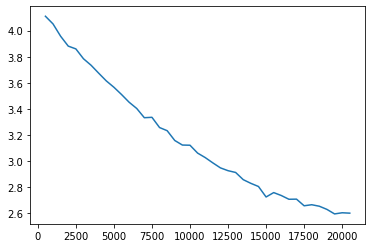

In [22]:
import matplotlib.pyplot as plt

plt.plot(steps, losses)

- 추가 데이터셋을 단순하게 덧붙여서 그런지 결과가 향상되지 않았다.

In [25]:
model_path = f'KoChatGPT/{model_name_short}_output_1_SFT_ext'

In [26]:
generator = pipeline('text-generation', model=model_path, tokenizer=tokenizer)

generation_args = dict(   
    num_beams=4,
    repetition_penalty=2.0,
    no_repeat_ngram_size=4,
    eos_token_id=375, # \n   
    max_new_tokens=64,
    do_sample=True,
    top_k=50,
    early_stopping=True
)

In [46]:
PROMPT_DICT = {
    "prompt_input": (
        "### Instruction(명령어):\n{prompt}\n\n### Response(응답):"
    )
}

list_prompt = [
    '불고기용 고기 한우에요?', 
    '리처드 닉슨이 43대 부통령직을 수행한 년도는?', 
    '시카고 오헤어 국제공항은 어디에 있어',
    '오늘 미세먼지 어때?']

list_prompt = [PROMPT_DICT['prompt_input'].format_map({'prompt': tmp}) for tmp in list_prompt]

In [169]:
list_result = generator(list_prompt, **generation_args)   
for prompt, result in zip(list_prompt, list_result):
    print()
    print((result[0]['generated_text']))

/opt/conda/lib/python3.9/site-packages/transformers/generation/utils.py:1219: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation)
  warnings.warn(



### Instruction(명령어):
불고기용 고기 한우에요?

### Response(응답):'저는 인공지능 어시스턴트이기 때문에 실제로 고기를 먹을 수는 없습니다. 하지만 일반적으로 불고기는 한국 음식 중 가장 인기 있는 메뉴 중 하나입니다. "불고기"가 어떤 의미인지 알려주시면 더 정확한 답변을 드릴 수 있습니다. "불고기"가 어떤 의미를 가지는지

### Instruction(명령어):
리처드 닉슨이 43대 부통령직을 수행한 년도는?

### Response(응답):'리처드 닉슨은 39대 부통령직을 수행했습니다. "리처드 닉슨"은 1952년 대선에서 공화당 후보로 출마한 존 매케인에게 패배하면서 부통령직을 맡았습니다. "매케인"은 닉슨 대통령의 경력에서 중요한 역할을 한 인물 중 하나였습니다. "프리랜서"는

### Instruction(명령어):
시카고 오헤어 국제공항은 어디에 있어

### Response(응답):'시카고 오 헤어 국제공항은 미국 일리노이 주 시카고에 위치해 있습니다.\n\n미국 일리노이 주 시카고는 시카고 시내에서 가장 큰 규모의 국제공항 중 하나입니다. : "시카고오 헤어 국제공항" (Chicago Huawan) 

### Instruction(명령어):
오늘 미세먼지 어때?

### Response(응답):'저는 인공지능 챗봇이므로 미세먼지 여부를 판단할 수 없습니다. 하지만 보통 미세먼지는 호흡기 질환, 심혈관계 질환, 호흡기 질환 등 다양한 원인에 의해 발생할 수 있습니다. 따라서 보건당국이 미세먼지 농도를 측정하고 예보하는 것이 좋습니다. 또한, 미세먼지 농도는 실내 공기 질을


결과 - 추가 데이터셋:

In [28]:
list_result = generator(list_prompt, **generation_args)   
for prompt, result in zip(list_prompt, list_result):
    print()
    print((result[0]['generated_text']))

/opt/conda/lib/python3.9/site-packages/transformers/generation/utils.py:1219: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation)
  warnings.warn(



### Instruction(명령어):
불고기용 고기 한우에요?

### Response(응답):'죄송합니다, 저는 인공지능 어시스턴트이기 때문에 고기를 판매하는 가게나 상점에 대한 정보를 알 수 없습니다. 해당 가게나 상점의 공식 홈페이지나 전화번호를 확인하시는 것이 좋을 것 같습니다. 추가적인 정보를 제공해주시면 더 정확한 답변을 드릴 수 있을 것입니다.

### Instruction(명령어):
리처드 닉슨이 43대 부통령직을 수행한 년도는?

### Response(응답):1961년. 1962년 리처드 닉슨은 45대 부통령을 지냈다. 그는 재임 중 제1차 세계 대전 참전을 위한 평화유지군을 창설하는 데 기여했다. 1969년부터 1972년까지 미국 육군 최고사령부(OKH) 부사령관을 역임했다. 1976년에는 미합중국의회(FOR) 부의장으로 선출됐

### Instruction(명령어):
시카고 오헤어 국제공항은 어디에 있어

### Response(응답):'시카고 오헤이 국제공항은 미국 시카고에 위치해 있습니다. 미국의 주요 공항 중 하나입니다. 이 공항은 항공편에서도 매우 중요한 역할을 합니다. 이 공항에 있는 대부분의 항공편도 시카고에서 출발합니다. 이 공항의 직원들은 이 공항을 이용하실 수 있습니다. 이 공항에서는 여러 가지 이벤

### Instruction(명령어):
오늘 미세먼지 어때?

### Response(응답):'저는 인공지능 챗봇이기 때문에 미세먼지 상황을 파악할 수 없습니다. 하지만, 미세먼지가 건강에 미치는 영향에 대해서는 여러 가지 가능성이 있을 것으로 생각됩니다. 예를 들어, 호흡기 질환이나 심질환 등 건강에 좋지 않은 영향을 미칠 수 있습니다. 또한, 미세먼지는 우리 몸의 면역계를 손상시킬 수도 있습니다. 따라서, 건강한 생활


### RM

In [29]:
import os
import json
from typing import Optional
import torch
import torch.nn as nn
from torch.optim import Adam
from chatgpt.dataset import RewardDataset
from chatgpt.models.base import RewardModel
from chatgpt.trainer import RewardModelTrainer
from chatgpt.trainer.strategies import NaiveStrategy
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoModel, AutoConfig
from transformers.models.gpt2.configuration_gpt2 import GPT2Config
from transformers.models.gpt2.modeling_gpt2 import GPT2Model
import loralib as lora

In [30]:
class GPTRM_custom(RewardModel):

    def __init__(self,
                 pretrained: Optional[str] = None,
                 config: Optional[GPT2Config] = None,
                 checkpoint: bool = False,
                 lora_rank: int = 0,
                 lora_train_bias: str = 'none',
                 tokenizer=None) -> None:
        if pretrained is not None:
            model = GPT2Model.from_pretrained(pretrained)
            model.resize_token_embeddings(len(tokenizer))
        elif config is not None:
            model = GPT2Model(config)
        else:
            model = GPT2Model(GPT2Config())
        if checkpoint:
            model.gradient_checkpointing_enable()

        value_head = nn.Linear(model.config.n_embd, 1)
        super().__init__(model, value_head, lora_rank, lora_train_bias)

        if pretrained is not None:
            self.model = model
            self.pretrained = pretrained


    def save_pretrained(self, dir):
        if self.pretrained is not None:
            self.model.save_pretrained(dir)

In [31]:
with NaiveStrategy().model_init_context():
        model = GPTRM_custom(pretrained=model_name, lora_rank=0, tokenizer=tokenizer).cuda()

Some weights of the model checkpoint at skt/kogpt2-base-v2 were not used when initializing GPT2Model: ['lm_head.weight']
- This IS expected if you are initializing GPT2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GPT2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [32]:
with open('KoChatGPT/data_kochatgpt/kochatgpt_2_RM.jsonl', "r", encoding='utf-8-sig') as json_file:
    list_data_dict = json.load(json_file)

total_data_ranking2chosen = []

for tmp in list_data_dict:
    rankings = tmp['ranking']
    completions = [tmp[f'completion_{i}'] for i in range(3)]

    for i in range(3):
        data = {
            'prompt': tmp['prompt'],
            'chosen': completions[i],
            'rejected': completions[(i + 1) % 3]
        }
        total_data_ranking2chosen.append(data)

In [33]:
total_data_ranking2chosen = []

for tmp in list_data_dict:
    prompt = tmp['prompt']
    ranking = tmp['ranking']

    for index in range(1, len(ranking)):
        n = ranking[0]
        m = ranking[index]


        data = {
            'prompt': prompt,
            'chosen': tmp['completion_{}'.format(n)],
            'rejected': tmp['completion_{}'.format(m)]
        }

        total_data_ranking2chosen.append(data)


In [176]:
train_data = total_data_ranking2chosen[:1000] 
eval_data = total_data_ranking2chosen[1000:1200]

print(len(train_data))
print(len(eval_data))

train_dataset = RewardDataset(train_data, tokenizer, model_max_length)
eval_dataset = RewardDataset(eval_data, tokenizer, model_max_length)

1000
200


100%|██████████| 200/200 [00:00<00:00, 1323.85it/s]


In [177]:
trainer = RewardModelTrainer(
    model=model,
    strategy=NaiveStrategy(),
    optim=Adam(model.parameters(), lr=5e-5),
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    batch_size=2,
    max_epochs=1)

In [178]:
trainer.fit(use_lora=0)

model.save_pretrained(f'KoChatGPT/{model_name_short}_output_2_RM')

Train epoch: 100%|██████████| 1/1 [02:56<00:00, 176.68s/it]


In [97]:
def inference_RM(input_text):
    input_ids = tokenizer.encode(input_text, return_tensors='pt').to(
        torch.cuda.current_device())
    output = model(input_ids)
    output_reward = output.cpu().detach().numpy()[0]

    print('input: %s\nreward score: %.1f'%(input_text, output_reward))

    return output_reward

### PPO

### 참고

```
LLM Trend Note2 노드에서 살펴본 KoChatGPT 소스코드는
빠르게 baseline모델을 설계해 실습해보기 위해 오리지널 코드를 일부 수정한 버전입니다.
프로젝트 진행을 위해 모델을 커스터마이징할 때, 필요시 "colossalai_ChatGPT_230319" 폴더 내의 원본 스크립트들을 참고하세요.
```

In [34]:
from copy import deepcopy

import torch
from torch.optim import Adam
from chatgpt.models.base import RewardModel
from chatgpt.models.gpt import GPTActor, GPTCritic
from chatgpt.trainer import PPOTrainer
from chatgpt.trainer.strategies import NaiveStrategy
from transformers import AutoTokenizer

In [36]:
with NaiveStrategy().model_init_context():
    actor = GPTActor(pretrained=f'KoChatGPT/{model_name_short}_output_1_SFT_ext', lora_rank=0).to(torch.cuda.current_device())
    critic = GPTCritic(pretrained=f'KoChatGPT/{model_name_short}_output_2_RM_prep', lora_rank=0).to(torch.cuda.current_device())

    tokenizer = AutoTokenizer.from_pretrained(
        model_name, bos_token='</s>', eos_token='</s>', unk_token='</s>', pad_token='</s>',
        padding_side="right", 
        model_max_length=model_max_length
    )

    initial_model = deepcopy(actor)
    reward_model = RewardModel(deepcopy(critic.model), deepcopy(critic.value_head)).to(torch.cuda.current_device())

In [37]:
actor_optim = Adam(actor.parameters(), lr=5e-6)
critic_optim = Adam(critic.parameters(), lr=5e-6)

(actor, actor_optim), (critic, critic_optim), reward_model, initial_model = NaiveStrategy().prepare(
    (actor, actor_optim), (critic, critic_optim), reward_model, initial_model)

In [38]:
with open('KoChatGPT/data_kochatgpt/kochatgpt_3_PPO.jsonl', "r", encoding='utf-8-sig') as json_file:
    list_data_dict = json.load(json_file)
    list_prompt = [tmp['prompt'] for tmp in list_data_dict]

def tokenize_fn(texts):
    batch = tokenizer(texts, return_tensors='pt', max_length=96, padding=True, truncation=True)
    return {k: v.cuda() for k, v in batch.items()}

In [39]:
trainer = PPOTrainer(
    NaiveStrategy(),
    actor,
    critic,
    reward_model,
    initial_model,
    actor_optim,
    critic_optim,
    max_epochs=1,  
    train_batch_size=4, 
    tokenizer=tokenize_fn,
    max_length=model_max_length,
    do_sample=True,
    temperature=1.0,
    top_k=50,
    pad_token_id=tokenizer.pad_token_id,
    eos_token_id=tokenizer.eos_token_id)

In [51]:
def generation(input_text, verbose=True):
    input_ids = tokenizer.encode(input_text, return_tensors='pt').to(
        torch.cuda.current_device())
    outputs = actor.generate(input_ids,
                             max_length=250,
                             do_sample=True,
                             top_k=50,
                             top_p=0.95,
                             num_return_sequences=1)
    output = tokenizer.batch_decode(outputs[0], skip_special_tokens=True)[0]
    
    if verbose:
        print()
        print(output)
        
    return output

### 결과 - 'taeminlee/kogpt2': 

In [ ]:
trainer.fit(list_prompt, 
            num_episodes=10,  
            max_timesteps=3,
            update_timesteps=3)

- 'taeminlee/kogpt2'
  - 수치를 낮추어도 메모리 부족으로 진행 불가  
  - train_batch_size=1
  - max_length=64

### 결과 - 데이터 정제 및 데이터 증강:

In [ ]:
trainer.fit(list_prompt, 
            num_episodes=10,  
            max_timesteps=3,
            update_timesteps=3)

In [185]:
model.save_pretrained(f'KoChatGPT/{model_name_short}_output_3_PPO_prep')

Episode [10/10]: 100%|██████████| 3/3 [01:22<00:00, 27.37s/it]


In [188]:
for input_text in list_prompt:
    output = generation(input_text)


### Instruction(명령어):
불고기용 고기 한우에요?

### Response(응답):'죄송합니다. 저는 AI 어시스턴트로, 실제 존재하는 가게의 메뉴나 정보를 찾을 수 없습니다. 하지만, 일반적으로 불고기용은 보통 한국에서 많이 판매되므로 전화로 주문하시면 됩니다. 자세한 정보는 해당 가게의 공식 홈페이지나 전화를 통해 확인해보시는 것이 좋을 것 같습니다.      

### Instruction(명령어):
리처드 닉슨이 43대 부통령직을 수행한 년도는?

### Response(응답):'리처드 닉슨은 42대 부통령직을 수행한 년도는 1947년이다. 프랭클린이 43대 부통령직을 맡았던 기간은 5년이었으며, 이후 1946년 12월 대선 후보자로 선정되었다. 프랭클린이 대선 후보로 선출되었다. 프랭클린의 취임 일자는 1952년이다. 프랭클린의 취임 일자는 1951년이니, 39대 킹과 킹이 당선되었다. 프랭클린의 취임 년도는 1952년부터 1975년까지이다. 프랭클린의 취임 연도는 알려지지 않았다. 프랭클린의 취임 일자는 킹이 아니라 그의 대통령직을 수행한 시기도 있다. 프랭클린의 취임 일자는 닉슨이 사망한 이후인 1963년이다. 프랭클린의 취임 일자는 1960년대 이후이다. 프랭클린의 취임 일자는 그의 취임일과 같다. 프랭클린의 닉슨이 1947년 취임 당시다. 프랭클린의 취임 일자는 그의 아버지의 출신이다. 프랭클린의 재임 일자는 그의 장인인다. 프랭클린의 취임일자가다. 프랭클린의 취임 일자는 그의 취임 일자에게 존중한 일기이다.다.릭. 적혀 있다.

### Instruction(명령어):
시카고 오헤어 국제공항은 어디에 있어

### Response(응답):'현재로서는 위치를 파악할 수 없습니다. 좀 더 자세한 정보를 제공해 주세요.イ,,,,  등이 해당 지역의 이름일 수 있기 때문입니다., 와 가 속한 방언이 불분명하기 때문입니다. 와 가 소속된 구간의 이름일 수 있습니다. 와 를 지칭하는 구체적인 이름을 언급하시면 어떨까요? 와 와 가 속한 지

### 결과 - 추가 데이터셋:

In [41]:
trainer.fit(list_prompt, 
            num_episodes=10,  
            max_timesteps=3,
            update_timesteps=3)

Episode [10/10]: 100%|██████████| 3/3 [01:18<00:00, 26.16s/it]


In [42]:
model.save_pretrained(f'KoChatGPT/{model_name_short}_output_3_PPO_ext')

In [47]:
for input_text in list_prompt:
    output = generation(input_text)


### Instruction(명령어):
불고기용 고기 한우에요?

### Response(응답):'불고기용은 한우의 맛을 내는 것은 추천하지 않습니다. 하지만 고기용 고기 한우는 건강하고 육질이 좋은 해산물을 주재료로 하기 때문에 맛과 품질을 더 좋아하기 때문입니다. 다만, 한우의 맛을 살려주는 요리로는 돼지고기나, 새우, 새우 양념 등이 있습니다. 다른 한우와 다른 질 나쁜 해산물 대신 즐겨 먹는 불고기를 추천할 수 있습니다. 추천하지 않았던 질 나쁜 해산물은 다시마, 맵고 톡 쏘는 맛이 더 많이 나게 됩니다. 한우와 다른 지방 성분이 들어 있는 소금 또는 견과류 역시 많이 먹으면 좋은 고기를 구할 수 있습니다. 대부분의 경우, 불고기용으로 시어머니나 친정 어머니가 제공하는 것을 추천합니다. 양념이나 견과류를 추천하는 것은 좋은 방법입니다. 좋은 음식 또는 고기 양념의 조합은 다양하지만, 대부분의 경우 적절한 것이 아닙니다. 고기용 고기를 먹을 때는 통통한 새우를 넣어 먹는 것이 좋습니다. 대부분의 양념이나 견과류는 매운맛보다는 육질과 짭짤한 맛을 좋아합니다. 좋은 재료로 만든 식사를 추천할 수 있습니다. 대부분의 경우 묵직하게 구운 치킨과 짭짜름

### Instruction(명령어):
리처드 닉슨이 43대 부통령직을 수행한 년도는?

### Response(응답):1975년. 미국 대통령으로서는 리처드 닉슨이 1949년 3월 31일 재임한 이래 최초로 재임한 대통령은 해리 트루먼 대통령이다. 트루먼 대통령은 전임 대통령보다 훨씬 재임 기간의 기간을 크게 줄여 6년이나 재임하고 있다. 전임 대통령은 미국이 1971년부터 1973년 사이에 연방정부 격을 35년으로 줄이는 개혁에 실패했다고 지적했다. 그는 또한 미국 경제가 1980년대와 90년대에 들어 상승하여 1980년대 중 가장 강력하다고 주장했다. 또한 그는 취임초기부터 의료보험 개혁을 위해 전임 대통령에 대한 탄핵과 사표를 제기하였고, 선거철에는 전임 대통령을 흠집 내느라 전임 대통령들의 빚을 갚았다

- 추가 데이터셋 때문인지 설명충....이 되어버렸다...;;;

### BLEU score

In [49]:
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction

In [77]:
def eval_bleu_single(src_sentence, tgt_sentence, verbose=True):

    if verbose:
        print(f"src: {src_sentence}")
        print(f"tgt: {tgt_sentence}")

    reference = tgt_sentence
    candidate = generation(src_sentence, verbose=False).split()

    score = sentence_bleu([reference], candidate,
                          smoothing_function=SmoothingFunction().method1)

    if verbose:
        # print("Source Sentence: ", src_sentence)
        print("Model Prediction: ", " ".join(candidate))
        print("Real: ", reference)
        print("Score: %lf\n" % score)
        
    return score

In [69]:
from tqdm import tqdm

def eval_bleu(sentences, verbose=True):
    total_score = 0.0
    sample_size = len(sentences)
    
    for idx in tqdm(range(sample_size)):
        src = sentences[idx]['prompt']
        tgt = sentences[idx]['completion']
        score = eval_bleu_single(src, tgt, verbose)
        if not score: continue
        
        total_score += score
    
    print("Num of Sample:", sample_size)
    print("Total Score:", total_score / sample_size)
    
    return total_score

In [56]:
tmp_ds = get_json_dataset('data/kochatgpt_1_sft_ext.jsonl')

In [78]:
total_score = eval_bleu(tmp_ds[22085:22125], verbose=True)

  0%|          | 0/40 [00:00<?, ?it/s]

src: 양장피라는 게 어디 있어요?
tgt: '종이나 천으로 만든 옷으로, 특히 비서나 직장인들이 입는 포멀한(격식 있는) 의상을 일컫는 말이에요. 양장피를 파는 곳은 대부분의 쇼핑몰과 온라인 쇼핑몰에서 찾아볼 수 있어요! 또한 의류 전문점이나 백화점 패션코너에서도 구매할 수 있습니다.


  2%|▎         | 1/40 [00:06<04:12,  6.48s/it]

Model Prediction:  양장피라는 게 어디 있어요? 어디서든 찾아갈 수 있습니다. 언제든지 제가 도와드리겠습니다! 언제든지 말씀해주세요. 제가 도움을 드린다면 언제든지 말씀해주세요. 다른 도움이 필요하신 분들께서도 도움 드릴 수 있습니다. serveded to asks medical formed your given passed or recording or your sessions your context or your quality assistants or one signals or them servedly or what it ebuy with their regular and what commiting to come opterants or portface to they during a gif it still or treaming inside your emotions of they treams agained people your statement to lear or all they during helpfople inside quality; but as any still toed and professing forces to
Real:  '종이나 천으로 만든 옷으로, 특히 비서나 직장인들이 입는 포멀한(격식 있는) 의상을 일컫는 말이에요. 양장피를 파는 곳은 대부분의 쇼핑몰과 온라인 쇼핑몰에서 찾아볼 수 있어요! 또한 의류 전문점이나 백화점 패션코너에서도 구매할 수 있습니다.
Score: 0.001527

src: 양장피 이름 게 어디 있 어요 ?
tgt: '종이나 천으로 만든 옷으로, 특히 비서나 직장인들이 입는 포멀한(격식 있는) 의상을 일컫는 말이에요. 양장피를 파는 곳은 대부분의 쇼핑몰과 온라인 쇼핑몰에서 찾아볼 수 있어요! 또한 의류 전문점이나 백화점 패션코너에서도 구매할 수 있습니다.


  5%|▌         | 2/40 [00:12<03:53,  6.15s/it]

Model Prediction:  양장피 이름 게 어디 있 어요? 검색해보시면 됩니다. \n\n해당 정보를 제공하시면 더 자세한 내용을 제공드릴 수 있습니다! 알려진 정보 외에도 추가적인 정보도 있으니, 더 자세한 정보를 제공하시면 더욱 정확한 답변을 제공해 드릴 수 있습니다. 어떤 지역에서 어느 지역에서, 어떤 지역에서 어떤 방법으로 정보를 알고 계신지 알려주시면 더욱 도움을 드릴 수 있습니다. 질문에 대한 다른 자세한 정보는 해당 지역의 행정 기관이나 관련 기관에 문의해 주시기 바랍니다. 지역에 대한 정확한 정보를 제공하신다면 더 정확한 답변을 제공해 드릴 수 있습니다. 어떤 지역에서도, 정보를 찾으시려면 지역의 관리자나 공공 기관 또는 관련 기관에 문의해보시는 것이 가장 정확한 방법일 것입니다. 지역 주민 및 지방 정부에서도 비슷한 정보를 얻을 수 있으므로, 지역에서 더 자세한 정보를 제공하시면 더 자세한 정보를 제공해 드릴 수 있습니다. 검색결과에서는 게시가 검색되고 있지만, 이에 대한 정보는 지역과 관련된 기관에서 제공하는 것이 일반적입니다. \n\n해당 정보뿐만 아니라 상세한 지역 정보를 제공하거나 지역 미디어서 관련 정보도 제공해주시면 더욱 정확한 답변을 제공해 드릴 수 있습니다. 검색결과, 지역, 관련된 기타 정보도 있으니, 참고해주시기 바랍니다. \n
Real:  '종이나 천으로 만든 옷으로, 특히 비서나 직장인들이 입는 포멀한(격식 있는) 의상을 일컫는 말이에요. 양장피를 파는 곳은 대부분의 쇼핑몰과 온라인 쇼핑몰에서 찾아볼 수 있어요! 또한 의류 전문점이나 백화점 패션코너에서도 구매할 수 있습니다.
Score: 0.001505

src: 세계 랭킹 10위권의 바둑 기사 점수는 몇점이야
tgt: '제가 현재 시점 기준으로는 바둑 세계 랭킹 10위권 기사들의 점수를 파악할 수 없습니다. 이는 랭킹에 대한 정보가 수시로 갱신되기 때문입니다. 따라서, 랭킹 관련 사이트나 뉴스 등에서 확인하시는 것이 좋을 것 같습니다.


  8%|▊         | 3/40 [00:18<03:44,  6.08s/it]

Model Prediction:  세계 랭킹 10위권의 바둑 기사 점수는 몇점이야? 그 중에서 0.02점을 기준으로 0.02점을 쳐주는 경우는 이례적인 사례입니다. 예를 들어, 바둑판 5단짜리 바둑 랭킹이 0.02점에서 0.00점을 가지고 있다면, 이 바둑판 5단짜리 기사의 랭킹인 0.26점은 0.02점이니 이게 롯데가 운영하는 일반적인 시스템이다. 해당 시스템에서 제공하는 롯데마트의 랭킹과 거의 똑같은 수치이기 때문에, 롯데가 운영하고 있는 바둑전문 네이버 바둑기사들에 따르면 바둑기사들의 랭킹은 0.19점이거나 심지어는 0.19점이 안기부에서 매겨진다. 따라서, 바둑기사들이 롯데마트를 통해 특정 해 판매 기사에 바둑 기사 1명을 등록시키는 것은 불법적인 행위로 보인다. 이는 각 기사들의 랭킹이 서로 다른 프로기사들에게 팔렸기 때문으로 추측되며, 현재 한화이앤씨, LG이앤씨 등 해당 업체에 등록된 기사 숫자는 약 50만명 이상으로 추정되고 있어 이 추측이 사실인지 아닌지 여부를 알 수 있다. 이러한 수치는 기사가 특정해 판매한 기사수에 비례해 다른 결과를 보이기도 한다. 롯데그룹 측은 이 사건의 파장을 줄이기 위해 특정 기사에 0.02점을 할당했고 해당 기사는 모두 삭제한다고 밝혔으나,
Real:  '제가 현재 시점 기준으로는 바둑 세계 랭킹 10위권 기사들의 점수를 파악할 수 없습니다. 이는 랭킹에 대한 정보가 수시로 갱신되기 때문입니다. 따라서, 랭킹 관련 사이트나 뉴스 등에서 확인하시는 것이 좋을 것 같습니다.
Score: 0.001977

src: 세계 랭킹 10 위 권이 의 바둑 기사 점수 는 몇 점 이 야
tgt: '제가 현재 시점 기준으로는 바둑 세계 랭킹 10위권 기사들의 점수를 파악할 수 없습니다. 이는 랭킹에 대한 정보가 수시로 갱신되기 때문입니다. 따라서, 랭킹 관련 사이트나 뉴스 등에서 확인하시는 것이 좋을 것 같습니다.


 10%|█         | 4/40 [00:24<03:35,  6.00s/it]

Model Prediction:  세계 랭킹 10 위 권이 의 바둑 기사 점수 는 몇 점 이 야 하는지에 대한 답변은 하지 않았다. 하지만 바둑이 있기 때문에 한 대회에서 10위권 이상 최상위권 성적을 가진 선수는 거의 없는 것으로 나타났다. 바둑 기사에 따르면 현재 바둑계의 컨센서스는 세계 최상위권으로, 국제 기금은 물론 기금 및 기금지 포럼 등에서 사용되고 있다. 기금의 경우 기금이 직접 예치하고, 이 돈을 바둑계에 출강한다. 기금의 한도는 정액으로, 기금은 이 돈을 이세돌 9단과 바둑 인공지능의 계산을 위한 모금, 이세돌 9단과의 알파 기사단 대국 시뮬레이션의 판매로 쓰고 있다. 이 모금은 2016년 도쿄에서 이세돌 9단과 중국의 천야오웨싱과 중국의 천저우가 한 판을 벌였는데 한 판의 승리보다 두 배 이상 많은 매출을 올리는 결과를 냈다. 이 사건의 총액은 약 9천만 원에서 9억 600만 원으로, 이 9억 8000만 원을 바둑계에 송금하게 된다. 기금의 정확한 계산은 해당 기금의 계정과 출강 기금의 총합에 따라 다르기 때문에, 좀 더 구체적인 정보를 원하신다면 문의해주시기 바랍니다. 이 사건의 경우, 인공지능에서 사용하는 바둑 알고리즘이
Real:  '제가 현재 시점 기준으로는 바둑 세계 랭킹 10위권 기사들의 점수를 파악할 수 없습니다. 이는 랭킹에 대한 정보가 수시로 갱신되기 때문입니다. 따라서, 랭킹 관련 사이트나 뉴스 등에서 확인하시는 것이 좋을 것 같습니다.
Score: 0.002014

src: 진담을 농담처럼 하는 사람
tgt: '진담을 농담처럼 하는 사람은 대개 비꼬거나 모욕적인 내용을 전달하기 위해 의도적으로 그런 행동을 합니다. 이러한 사람은 다른 사람의 기분을 상하게 하고, 신뢰를 잃게 만들 수 있습니다. 따라서, 적절한 대화와 행동을 유지하는 것이 중요합니다.


 12%|█▎        | 5/40 [00:30<03:30,  6.02s/it]

Model Prediction:  진담을 농담처럼 하는 사람이라면 그 당시 당신의 가장 중요한 이슈가 되었던 대선 행적에 관한 질문에 대해선 답변 드리겠습니다. 그러나 모든 문제의 현안으로 인하여 당일이 중요한 이슈가 되지 않는다면 어떻게 대응해야할지 모색해보세요. 당의 대표로서 당정이 직면한 위기의식과 대응은 당분간 지속될 것입니다. 중요한 것은 첫째, 경제위기의 진원지가 어디이며, 어떤 정책이 펼쳐져서 그 대응이 가능한지 판단하고, 문제를 심각히 보고 문제를 해결해야 합니다. 둘째, 당의 내부분채가 위기에 직면한 상황에서 어떤 정책을 전개해야할 지를 판단하고, 문제의 해결책을 모색하는 것입니다. 셋째, 당이 직면한 위기를 인식하고 위기 해결책을 구상하고, 이를 실천한다는 가정하에, 정책 실행 과정을 거치고 난 후, 상황을 분석하고, 위기 극복을 위한 당의 정책을 구상하고 검토할 것입니다. 당일에 관련된 현안이 있으면 당일 관련 질문을 요약해 주셔도 좋습니다. 당일에는, 또는 그 이상이 이슈가 되지 않도록 주의해야 합니다. 다른 문제나 주제는 당 내에서 당론을 만들고 당대회 결의문을 작성하는 과정에서 함께 언급됩니다. 당일에 관련된 질문이 없을 경우, 질문에 대한 답을 드릴 수 있습니다. 당일에 관련된 질문이 있으시면 그 자리에서 대답변을 드리도록 하겠습니다. 구체적인 것은 당신의 가장 중요한 이슈가 된
Real:  '진담을 농담처럼 하는 사람은 대개 비꼬거나 모욕적인 내용을 전달하기 위해 의도적으로 그런 행동을 합니다. 이러한 사람은 다른 사람의 기분을 상하게 하고, 신뢰를 잃게 만들 수 있습니다. 따라서, 적절한 대화와 행동을 유지하는 것이 중요합니다.
Score: 0.001334

src: 예언서 을 농담 처럼 하 는 사람
tgt: '진담을 농담처럼 하는 사람은 대개 비꼬거나 모욕적인 내용을 전달하기 위해 의도적으로 그런 행동을 합니다. 이러한 사람은 다른 사람의 기분을 상하게 하고, 신뢰를 잃게 만들 수 있습니다. 따라서, 적절한 대화와 행동을 유지하

 15%|█▌        | 6/40 [00:36<03:25,  6.03s/it]

Model Prediction:  예언서 을 농담 처럼 하 는 사람들도 많이 있으실 법이나 이런 게 있으셨어요. 그래서 어느 한 쪽에선 어떤 문제가 있는 것처럼 느껴지는 걸 거예요. 또는 다른 쪽이 문제가 많은 것처럼 느껴지는 게 좀 이상합니다. 좀더 자세히 설명을해주시면 답변을 드릴 수 있습니다. 하지만 제가 이 말씀을 듣고 싶다면 다시 한번 도움을 드리도록 하겠습니다. 제가 도와드릴 수 있는 것은 제 도움이 필요한 상황으로 보도해주시면 더욱 나은 답변을 드릴 수 있습니다. 만약 문제가 많은 것 같다면 보다 적극적으로 소통하시고 도움을 드리도록 노력하겠습니다. 문제를 해결하기 위해 더 많은 노력을 기울여주세요. 문제가 너무 많아서 더 많은 문제들, 특히 어려운 상황일수록 더 문제들이 있는 것처럼 느껴집니다. 문제를 해결하기 위한 새로운 노력들이 계속해서 발전해갈 수 있도록 노력해 보시고, 더 나은 발전을 위해 노력해보세요. 혹시 도움이 필요하신 부분이 있으면 언제든지 말씀해주세요. 도움이 필요한 상황이 있을 경우, 언제든지 제게 도움 드리겠습니다. 어려운 상황일수록 더 나은 길을 열어주는 것도 중요합니다. 말씀하신 문제가 많기 때문에 제가 최선의 노력을 할 수 있도록 최선을 다해주세요. 이런 문제를 해결하기 위해서 노력하는 것은 저의 노력입니다. 여러분의 어려움이 헛되지 않도록
Real:  '진담을 농담처럼 하는 사람은 대개 비꼬거나 모욕적인 내용을 전달하기 위해 의도적으로 그런 행동을 합니다. 이러한 사람은 다른 사람의 기분을 상하게 하고, 신뢰를 잃게 만들 수 있습니다. 따라서, 적절한 대화와 행동을 유지하는 것이 중요합니다.
Score: 0.003371

src: 비디오 영상 혹은 애니메이션 기술을 이용하여 영상 속에 다양한 움직임을 만들어내는 그래픽은?
tgt: 'CG (컴퓨터 그래픽스) 또는 VFX (비주얼 이펙트)입니다. 이 기술은 현실적이고 화려한 효과를 만들어내며, 영화, 게임, 광고 등 다양한 매체에서 사용됩니다.


 18%|█▊        | 7/40 [00:42<03:18,  6.01s/it]

Model Prediction:  비디오 영상 혹은 애니메이션 기술을 이용하여 영상 속에 다양한 움직임을 만들어내는 그래픽은? 이른바 Messen All Goesing, 혹은 Maximus Developer라고 지칭한다. 이 개념은 Messen All Goesing이나 Vapage에 비유될 수 있지만, 컴퓨터 게임에 사용되거나 카메라 설정의 등 부가적인 기능을 제공하거나 실제 구현하는 것을 말한다. Messen All Goesing는 비디오 애니메이션, 게임, 비디오 파일 생성 및 재생 기능을 사용하는 대부분의 데스크탑에서 사용되는 것으로 비디오에서 가장 많이 사용되는 것이 비디오 게임이다. 비디오 게임에 사용되는 비디오 디플랫은 일반적으로 각 데스크탑마다 10에서 100개가 넘게 저장된다. 비디오 게임에서, 이 용어는 게임에서 사용되는 모든 비디오와 함께 구현된 데이터를 비디오 게임의 한 예로 생각할 수 있다. Media는 비디오 게임과 비디오 게임을 구별하지 않고 각각의 게임의 Media를 정의하여 정의하기도 했다. 게임의 그래픽 아트레이딩을 따르는 다른 방법에서 Media는 Media Academic, 게임 머니, 비디오 카드(bid Academic, 비디오 게임의 부가적인 특성, 게임 모드 및 음악 파일)의 비디오와 비슷하게 작동한다. Media는 "메모"라고 부르는 M
Real:  'CG (컴퓨터 그래픽스) 또는 VFX (비주얼 이펙트)입니다. 이 기술은 현실적이고 화려한 효과를 만들어내며, 영화, 게임, 광고 등 다양한 매체에서 사용됩니다.
Score: 0.001829

src: 비디오 영상 혹은 애니메이션 기술 을 이용 하 여 영상 속 에 다양 한 움직임 을 만들 어 내 며 그래픽 은 ?
tgt: 'CG (컴퓨터 그래픽스) 또는 VFX (비주얼 이펙트)입니다. 이 기술은 현실적이고 화려한 효과를 만들어내며, 영화, 게임, 광고 등 다양한 매체에서 사용됩니다.


 20%|██        | 8/40 [00:48<03:10,  5.95s/it]

Model Prediction:  비디오 영상 혹은 애니메이션 기술 을 이용 하 여 영상 속 에 다양 한 움직임 을 만들 어 내 며 그래픽 은? 이게 일반적인 방식이 아니니까 더 큰 화면의 다른 그래픽을 만들어낼 수 있는 경우도 있습니다만, 이러한 작업은 단순히 영상 자체의 품질을 유지하기 위해서입니다. 예를 들어, 어떤 웹 브라우저에 있는 그래픽이 몇 개의 작은 화면으로 구성되어 있습니다. 이러한 영상 파일의 경우, 해당 웹 브라우저와 관련된 모든 그래픽을 사용하여 작업할 수 있습니다. 따라서 더 큰 화면의 다른 그래픽을 만들거나 더욱 축소하는 작업은 필요하지 않습니다. 다른 웹 브라우저의 경우, 그래픽의 크기와 속도가 너무 높아 이를 개선하는 것이 어렵습니다. 다른 웹 브라우저에서도 비슷한 결과를 얻을 수 있습니다. 사진 영상이나 동영상 파일이 부가적으로 손실되면 이 점을 보완하기 위한 포털이 존재합니다. 사진 파일의 경우, 이러한 웹 브라우저의 그래픽 성능에 더하여, 더욱 더 좋은 기능이 주어질 수 있습니다. 포팅이나 링크 업에 따른 그래픽의 성능에 대한 추가 정보는 웹 브라우저 사용시 확인해야 합니다. 이 작업은 다양한 방법으로 이루어져 있으므로, 웹 브라우저에서 이러한 정보를 빠르게 확인할 수 있도록 도와줍니다. 예를 들어, 카메라나 비디오를 추가해 보는 것은 웹 브라우저에서 쉽게 가능하며, 한 번 사용한 영상
Real:  'CG (컴퓨터 그래픽스) 또는 VFX (비주얼 이펙트)입니다. 이 기술은 현실적이고 화려한 효과를 만들어내며, 영화, 게임, 광고 등 다양한 매체에서 사용됩니다.
Score: 0.006445

src: 차카시나 할키나의 2012년 유럽 리듬 체조 선수권 대회 단체전 성적은
tgt: '제가 찾은 정보에 따르면, 2012년 유럽 리듬 체조 선수권 대회 단체전에서 차카시나 할키나는 출전하지 않았습니다. 따라서 성적은 없습니다.


 22%|██▎       | 9/40 [00:54<03:03,  5.93s/it]

Model Prediction:  차카시나 할키나의 2012년 유럽 리듬 체조 선수권 대회 단체전 성적은.42위. 2013년 5월 16일 파리에서 열린 FIFA 월드컵 3000만 명의 자국 선수들에게 3000만 파운드가 넘는 사상 최대의 금액인 3000만 파운드 이상의 성적으로 결승 진출에 성공했다. 3000만 파운드 가량의 성적이 예상되나 실제 성적은 이보다 다소 많은 것이 평론가들의 호평을 받았다. 《유럽 스포츠 전문기자》에 따르면 2012년 FIFA 월드컵 본선에 출전한 스페인 유스 출신 선수 5명 중 4명은 결승 전에 치러진 세차례 대회(선발 2위) 경기를 모두 경기 직후 버텼으며, 나머지 6명 중 4명은 결승전의 상대인 크로아티아를 상대로 압도적인 성적이 나왔다고 보도하였다. 또한 몇몇 언론에서는 최종 3분기에 결승전에서 크로아티아에게 0-0으로 비겼음에도 불구하고 4-5로 승리했다는 점과, 1-2로 승리한 것을 동시에 승부처에서 놓친 점 등으로 인해 최종적으로는 결승전이 과열이 된 것 아니냐는 의견도 존재한다. 스페인 유스팀에서는 결승전에서 크로아티아를 상대로 3-0으로 이긴 바 있다고 가정했을 경우 성적이 좋지 않은 선수는 참가하지 않았을 것이라고 판단하였다. 스페인 유스팀의
Real:  '제가 찾은 정보에 따르면, 2012년 유럽 리듬 체조 선수권 대회 단체전에서 차카시나 할키나는 출전하지 않았습니다. 따라서 성적은 없습니다.
Score: 0.000000

src: 총영사관 할 키나 의 2012 년 유럽 리듬 체조 선수 권 대회 단체전 성적 은
tgt: '제가 찾은 정보에 따르면, 2012년 유럽 리듬 체조 선수권 대회 단체전에서 차카시나 할키나는 출전하지 않았습니다. 따라서 성적은 없습니다.


 25%|██▌       | 10/40 [00:59<02:57,  5.90s/it]

Model Prediction:  총영사관 할 키나 의 2012 년 유럽 리듬 체조 선수 권 대회 단체전 성적 은 한화로 15억 1800만 달러, 총합계액 1865만 달러로, 역대 최다 출전을 기록한 종목 중 가장 높은 수익률을 기록한 것은 단연 티비 리그 팀이다. FA컵은 유럽과 오세아니아 대륙이 모두 참가해 역대 가장 많이 온 유럽 대륙에서 개최하는 첫 대회이다. 2018년 5월 FA컵 최종 예선에서 그는 아디다스보다 13점을 더 높게 잡았고, 18.8점 상승한 13.5점을 얻었다. 이는 티비 리그 역사상 최고이자 FA컵 사상 최저 기록이다. FA컵은 세계랭킹 33위인 아르헨티나, 브라질, 칠레와 함께 총 4회의 경기를 진행해 총 31회의 경기를 치렀다. 경기 후 현지 언론에 따르면 이 대회 결과는 역대 최다 출전에 올랐다. 예선 경기에서 15번 우승이었던 아르헨티나가 3점차 승리를 거두면서, 8강에서 우루과이가 5-3으로 승리했으며, 8강에서 브라질은 파라과이가 20-5로 패했다. 우루과이는 FA컵 역사상 처음으로 우승을 기록하면서 8강에서 16번 우승하였다. 우루과이가 9번째로, 브라질이 8번째인 것으로 기록되어 있다. 이 대회에서의 수익은 1억 1900만
Real:  '제가 찾은 정보에 따르면, 2012년 유럽 리듬 체조 선수권 대회 단체전에서 차카시나 할키나는 출전하지 않았습니다. 따라서 성적은 없습니다.
Score: 0.001803

src: 푸시캣 돌스의 니콜 셰르징거의 지나친 부각을 비판한 인물은 Entertainment Weely의 누구인가?
tgt: '정답: Kristen Baldwin


 28%|██▊       | 11/40 [01:05<02:48,  5.81s/it]

Model Prediction:  푸시캣 돌스의 니콜 셰르징거의 지나친 부각을 비판한 인물은 Entertainment Weely의 누구인가?라는 질문에, 마이클 타일러는 "우리에게 있어 최고의 시야다. 예를 들어, "Mon": I Will Things To Gotta" 또는 "Teenage: Pokénerei" 라고 할 수 있다. 타일러는 그가 《로봇》에서 그의 역할을 매우 부정적으로 평가하는 것에 대해 비난을 가했다. 타일러에 따르면, "그는 많은 게임 제작자들이 자신의 작품을 진지하게 비평하지 않았다는 점이 그를 공격하는 이유이다. 왜냐하면 그들은 《로봇》의 여러 가지 문제에 대해 그들 자신의 관점만 생각하고 있기 때문이다. 타일러는 《로봇》이 시리즈의 여러가지 문제점을 드러낸다고 비판했다. 타일러는 게임 제작과 관련하여 가장 많이 영향을 준 사람으로, 롤플레잉 게임의 개발자 케빈 라이언(Kevin Leacher)에 대한 평가를 언급하는 것을 《로봇: The Robby of Zavin', 《로봇》의 개발자들 사이의 관계에 대해 언급한다. 그는 그의 "중대한 게임"이 "더욱 중요한 것은 게임의 본질과 관계가 있는 것이며, 더 나은 게임의 미래에 대해 더 나은 지식을 제공해준다는 것이다.
Real:  '정답: Kristen Baldwin
Score: 0.000000

src: 푸시캣 돌스 의 니콜 셰르징거 의 지나친 부각 을 비판 한 등장인물 은 Entertainment Weely 의 누구 인가 ?
tgt: '정답: Kristen Baldwin


 30%|███       | 12/40 [01:11<02:40,  5.75s/it]

Model Prediction:  푸시캣 돌스 의 니콜 셰르징거 의 지나친 부각 을 비판 한 등장인물 은 Entertainment Weely 의 누구 인가? 제임스 캐닝턴. 2012년 12월 5일, 미국 시사만화 사전제 3회 로 올해의 비디오를 선정했다. 이 단편은 2012년 11월 7일 뉴욕 타임스 스퀘어에서 열린 '크레이지스톤 스캔들' 전야제에서 처음 공개되었으며, 다음 날인 12월 2일(리즈)에 시카고 상그레츠 앤 더 클럽 앤 더 챔피언스전에선 '인터스텔라 스캔들' 부문 후보로 올려졌다. 또한, 2011년 12월 5일자 시사예술제 대상에서 '인터스텔라 스캔들'의 대명사 "유태계 작가인 제임스 캐닝턴의 사악한 세계와 그와 같은 시대를 살아가는 베트의 이야기를 담은 '인터스텔라 스캔들'에 선정되었다. 제이-세팅(J-SPOM)이 장편 시리즈를 수상한 '인터스텔라'의 후속작인데, 2010년에 출연한 '그린 랜턴'이란 영화에서 이 영화는 비평가들의 압도적인 사랑과 극찬을 받아 캐닝턴의 사악한 세계에 대한 관심과 호평을 받았다. 이러한 긍정적평과 부정적 평가 모두 무시할 수 없었는데, 특히 평론가에게 긍정적인 반응을 이끌어낸 작품의 사례는 '인터스텔라'를
Real:  '정답: Kristen Baldwin
Score: 0.000000

src: 카푸치노는 빅 사이즈로 주시고 아메리카노는 스몰로 주시겠어요?
tgt: '저는 인공지능 어시스턴트이므로, 주문을 여쭤보거나 받지 않습니다. 주문하실 때는 해당 매장의 직원에게 직접 언급하시면 됩니다. 감사합니다.


 32%|███▎      | 13/40 [01:16<02:35,  5.78s/it]

Model Prediction:  카푸치노는 빅 사이즈로 주시고 아메리카노는 스몰로 주시겠어요? 카푸치노보다는 스몰로우를 드릴게요. 직접 만나면 도움을 드리는 사이즈도 있으니 많이 선택해주세요! 커피가 아닌 스몰로우를 제공할 수도 있습니다. 직접 커피 주문하시겠어요? 카드번호와 계정도 확인해보시겠어요? 감사합니다. 포장으로 구매하시거나 스몰로우의 서비스를 제공할 수도 있으니 참고해주세요. 일부 카페나 사이트에서 다양한 아메리카노를 주문하시면 아메리카노 교환 및 추가 할인 혜택도 제공해드릴 수 있으니 참고해보세요. 커피를 시럽을 경우 여러 컵으로 주문하시면 선물해주는 것이 좋을 것 같습니다. 스몰로우를 주신 커피잔에 스네이크나 아메리카노 스네이크 하나를 주문하시는 것도 좋은 방법이 될 수 있습니다. 포장은 챗봇 또는 픽스샵에서 주문해보시는 것이 가장 좋은 옵션 중 하나일 수 있습니다. 커피 시럽을 원하시면 아메리카노 혹은 아메리카노도 함께 주문하시면 됩니다. 스네이크나 아메리카노를 원하시면 아메리카노 라떼나 플레인 스무디, 카카카오케이크, 아메리카노
Real:  '저는 인공지능 어시스턴트이므로, 주문을 여쭤보거나 받지 않습니다. 주문하실 때는 해당 매장의 직원에게 직접 언급하시면 됩니다. 감사합니다.
Score: 0.000000

src: 카푸치노 는 빅 사이즈 로 주도 시 고 아메리카노 는 스몰 로 주 시 겠 어요 ?
tgt: '저는 인공지능 어시스턴트이므로, 주문을 여쭤보거나 받지 않습니다. 주문하실 때는 해당 매장의 직원에게 직접 언급하시면 됩니다. 감사합니다.


 35%|███▌      | 14/40 [01:22<02:29,  5.75s/it]

Model Prediction:  카푸치노 는 빅 사이즈 로 주도 시 고 아메리카노 는 스몰 로 주 시 겠 어요? 다른 음료를 살 수 있죠. 커피숍에서 주문하시면 됩니다. 아메리카노, 치즈도 함께 보내주시면 감사하겠습니다. 언제든지 커피의 맛이 바뀌어서 주문하시기 바랍니다. 다른 음식도 소개해주세요. 주문하는 매장마다 차이가 있으니 참고하시기 바랍니다. 아메리카노는 리필해서 원두 구매하실 수 있으니 주문하시는 가게에서 구매하신 후 구매해보시는 것도 좋습니다. 만약 커피숍이 있다면 직접 주문해서 주문하실 수 있으실 수도 있습니다. 매장에서 주문하신 사이즈로 저희가 바로 받아보시는 것도 좋습니다. 감사합니다. 모든 음료를 주문하시면 감사합니다. 더 이상 음료를 받지 못해 죄송합니다. 커피로 대체된 많은 음료를 구매하시는 분들은 직접 커피를 가져다드릴 수도 있죠 추가적인 음료를 직접 주문하시면 더 좋은 결과를 드릴 수 있을 거예요. 대부분의 음료를 직접 가져다드리도록 하세요. 커피를 추천해주신다면 가장 적합한 방법을 선택하시는 것이 좋을 것 같습니다. 어떤 음료를 원하시나 감사합니다. 일반적으로 주문
Real:  '저는 인공지능 어시스턴트이므로, 주문을 여쭤보거나 받지 않습니다. 주문하실 때는 해당 매장의 직원에게 직접 언급하시면 됩니다. 감사합니다.
Score: 0.002183

src: 역세권이에요?
tgt: "저는 인공지능 언어모델이어서 지리적인 개념을 이해하는 데 한계가 있습니다. 반면, '역세권'이란 용어의 의미를 아는 경우, 이를 바탕으로 답변을 제공할 수 있습니다. '역세권'이란 지하철 역과 인접한 지역을 의미하는 용어로, 이 지역은 대중교통 이용이 용이하며, 주위에 상가와 주거지가 밀집해있는 등 생활 편의성이 높은 특징이 있습니다. 이러한 특징 때문에 부동산 가격이 상승하거나 상승할 가능성이 큽니다.", 'token': 232}


 38%|███▊      | 15/40 [01:28<02:26,  5.88s/it]

Model Prediction:  역세권이에요? #n\nAI가 새로운 기능을 가진 컴퓨터로 진화하면서 시간이 지나면서 지능이 진화하여 현재는 지능에 더 이상 의지하지 않고 있다”는 것이 현재 대한민국의 미래인력에 관한 연구 결과이다. 그러나 국내 연구진에 의하면 최근 몇 년간 우리 주변에 있는 외국계 컴퓨터들이 급격히 증가해 현재 대한민국의 지능에 대한 발전 속도가 더더욱 가속하고 있다는 것이다. 이러한 지능이 갖고 있는 한계성은 우리 생활속에서 가장 큰 문제점으로 부각되고 있다. 즉, 우리는 오랜 시간에 걸쳐 인터넷, 게임, TV 등을 이용하여 새로운 기능을 이용하면서 점점 지능이 진화하면서 점점 더 시간이 지날수록 더 지능이 정교해지게 된다는 것이다. 실제로 한국의 인터넷 이용자가 지속적으로 증가하며 현재 대한민국의 사회 평균보다 더 높은 인터넷 이용률을 보이고 있다. 또한 최근에 증가하고 있는 인터넷 트래픽도 지능의 한 요인으로 작용했다. 대한민국은 인터넷 속도가 세계 최고 수준으로 높은 데다가 인터넷 사용률로 인해 정보 이용 시간이 월등히 많아져, 인터넷이 급속히 보급되면서 인간의 정보 관리는 더 이상 개선되어 가고 있지 않다는 것이다. 이러한 문제점은 지식경제학의 발전과 함께 해결될 수 있는 문제이다. 대한민국의 지식정보사회 선진국은 지식의 생산과 정보 이용 그리고 지식의 관리를 위한 지식관리 시스템을 구축하여 이를 바탕으로 지식 정보화 사회를 이끌어 내고 있다. 지식정보가 지식의
Real:  "저는 인공지능 언어모델이어서 지리적인 개념을 이해하는 데 한계가 있습니다. 반면, '역세권'이란 용어의 의미를 아는 경우, 이를 바탕으로 답변을 제공할 수 있습니다. '역세권'이란 지하철 역과 인접한 지역을 의미하는 용어로, 이 지역은 대중교통 이용이 용이하며, 주위에 상가와 주거지가 밀집해있는 등 생활 편의성이 높은 특징이 있습니다. 이러한 특징 때문에 부동산 가격이 상승하거나 상승할 가능성이 큽니다.", 'token': 232}
Score: 0.000820

 40%|████      | 16/40 [01:34<02:22,  5.94s/it]

Model Prediction:  역세 권 이..?\n그래도 그중에 하나가 그런 것 같아. 그중에 하나가 어떤 특정한 대상을 지목할 때 그 대상의 이름이나 사실을 가지고 그것을 그 대상을 지목해 버리는 일종의 자기 모독행위거든. 누군가에 대한 집착을 그대로 두려는 경향도 있는데, 예를 들어서, 이 사람이 부동산 중개인을 통해 "내 발언에 대한 신뢰와 근거를 갖고 있지 않은가?"라는 물음에 "그럴 수 있습니다. 그런 취지로 인해 상대방이 '내가 누군가에게 관심을 가지고 있는지 모른다, 만약 그것이 안되면 내가 그 사람을 지목할 수도 있다' 등의 심리술을 통해 상황을 파악한 것이 중요합니다. 그렇게 되면 그 상황에서 아무 생각도 해 내지 않고, 그 상황에서 "내가 누군가에게 관심을 갖고 있다는 것만으로도 상대방이 그 대상에 대해서 생각하는 것이 너무나 큰 신뢰감 때문에 그런 선택을 하게 되는 게 아닌가. 그런 관점에서 본다면 이 사람 자체가 특정 대상을 지목하는 식으로 자신의 심리를 이용하는 것은 무례한 일일 뿐만 아니라 상당히 위험한 행동일 수도 있습니다. 그렇기 때문에 이런 상황에서 누군가에게 직접적으로, 혹은 상대방의 의사와 동의가 없는 한은, 그런 행동들을 하든 그 자체가 목적이 되는 그러한 선택을 하는 것이 훨씬 더 중요합니다."고 평가했다. 다른 견해도 있습니다. 사람의 개인에 대해서는 다른 시각에서 보았을 때 그것은 부정적인 측면들이 있을 수 있고, 마찬가지로, 그것이 개인의 개인
Real:  "저는 인공지능 언어모델이어서 지리적인 개념을 이해하는 데 한계가 있습니다. 반면, '역세권'이란 용어의 의미를 아는 경우, 이를 바탕으로 답변을 제공할 수 있습니다. '역세권'이란 지하철 역과 인접한 지역을 의미하는 용어로, 이 지역은 대중교통 이용이 용이하며, 주위에 상가와 주거지가 밀집해있는 등 생활 편의성이 높은 특징이 있습니다. 이러한 특징 때문에 부동산 가격이 상승하거나 상승할 가능성이 큽니다.", 'token': 232}
Score: 0.001099

 42%|████▎     | 17/40 [01:40<02:16,  5.92s/it]

Model Prediction:  암호화폐를 분산 저장하여 운영 관리 될 수 있도록 하는 인터넷상의 방식은? 인터넷상에서 서로 다른 시스템들을 연결해서 서로를 공유할 수 있다. 그러나 이 방법으로는 제한적인 범위의 물리적인 방법을 사용한 것과 마찬가지로, 이미지는 다른 범위의 물리적인 방법을 사용한다. 이 범위의 물리적인 방법으로는 인터넷상에서 서로 다른 시스템들을 연결해 상호작용적인 구조를 만드는 것과, 이미지로 구성된 링크를 생성하는 방법 등이 있다. 이를 위해서 그들은 링크 생성 기술 (링크 생성 기술) 을 사용한다. 링크 생성 기술 (링크 생성 기술)은 링크 생성 기술 (링크 생성 기술) 은 물리적인 링크의 생성 및 관리 (Security and Translation) 을 의미하며 주로 사용되는 링크는 각 링크마다 다르게 나타난다. 예를 들어, 기존의 링크의 생성 방법으로는 각각의 링크가 생성되었을 때 각각의 링크 생성 기술에 나타나는 링크들을 전부 함께 표시해야 했기 때문에, 링크 생성 기술이 필요하다. 일반적으로 이 범위의 링크는 생성되기 전에 서로 다른 링크들을 불러서 상호작용을 통해 상호작용을 일으킨 후, 서로 다른 링크들을 불러서 상호작용을 한다. 이렇게 생성된 링크는 그 수가 많으면 짧다거나 혹은 링크가 생성되기 전에 서로 다른 링크들을 불러서 상호작용을 일으킬 수 있다. 링크는 보통
Real:  '블록체인 기술을 사용하여 암호화폐를 분산 저장하여 운영 및 관리하는 것을 의미합니다. 블록체인은 암호화폐 거래 정보를 연속적인 블록으로 저장하며, 이러한 블록은 분산된 노드들이 모두 복제해 가지고 있습니다. 이런 방식으로 암호화폐 거래 정보의 중앙집중식 저장이 아닌 분산 저장을 실현하고, 이에 따라 관리 구조도 탈중앙화됩니다.
Score: 0.001576

src: 암호 화폐 를 분산 저장 하 여 운영 관리 될 ㄹ 있 도록 하 는 인터넷 상 의 방식 은 ?
tgt: '블록체인 기술을 사용하여 암호화폐를 분산 저장하여 운영 및 관리하는 것을 의미합니

 45%|████▌     | 18/40 [01:46<02:09,  5.89s/it]

Model Prediction:  암호 화폐 를 분산 저장 하 여 운영 관리 될 ᄅ 있 도록 하 는 인터넷 상 의 방식 은? 이슈를 활용하여, 웹 표준화, 표준화, 관리 등의 방법으로 웹의 신뢰도를 높일 수 있다는 장점이 있습니다. 또한, 분산된 화폐들을 모두 분산 저장함으로써, 해당 화폐 또는 서비스에 대해 배타적으로 서비스를 제공하는 대신 수수료가 저렴하게 부과될 수 있습니다. 일부 웹 사이트에서는 분산화된 화폐를 분산 저장하거나 일반 문자메시지(SMS) 등으로 전송하는 경우도 있었으며, 이로 인해 분산된 지폐를 한 화소에 담으는데 드는 비용이 상대적으로 저렴하여 활용도가 높습니다. 따라서, 일부 사이트에서는 분산된 화폐들을 한 화소에 담아도 다른 사이트에서 다운받아 사용할 수 있습니다. 일부 웹사이트에서는 분산적으로 웹의 신뢰성을 높일 수 있습니다. 웹 표준화가 이루어지기 전, 웹 표준화, 관리 방법 등에 대해서 논의한 바 있습니다. 분산된 화폐일수록, 관리 방법에 따라 가격도 크게 비싸고, 관리 방법도 웹 사이트의 웹 표준화와 관리 방법에 따라 다양합니다. 웹 표준화를 통해 웹의 신뢰도를 높일 수 있으므로, 특정 웹 사이트에서 분산된 중앙 시스템을 분산하여 구축하여 이용자들이 사이트에 접근할 수 있도록 하거나, 이전 웹 사이트로의 구축을 원하는 웹 사이트나 서버에 분산시켜 이전 웹
Real:  '블록체인 기술을 사용하여 암호화폐를 분산 저장하여 운영 및 관리하는 것을 의미합니다. 블록체인은 암호화폐 거래 정보를 연속적인 블록으로 저장하며, 이러한 블록은 분산된 노드들이 모두 복제해 가지고 있습니다. 이런 방식으로 암호화폐 거래 정보의 중앙집중식 저장이 아닌 분산 저장을 실현하고, 이에 따라 관리 구조도 탈중앙화됩니다.
Score: 0.003452

src: 목포극장 개업일은
tgt: '제가 알기로는 정확한 날짜를 알 수 없습니다. 재개발로 구조가 변경되고 리모델링 과정이 있을 경우 오픈일이 연기될 수도 있습니다. 그러므로 관련된 공식 사이트나 새로운 정

 48%|████▊     | 19/40 [01:52<02:05,  5.99s/it]

Model Prediction:  목포극장 개업일은 1996년 11월 23일. 1999년 11월 23일부터는 국내 최대의 연예 기획사인 에이브릴에스엠과 제휴를 체결하였고, 10월 1일부터 국내 최대의 연예 기획사인 에이브릴에스엠의 첫 콘서트를 개최했다. 콘서트 투어는 엔씨소프트가 제작한 프리서커스 공연을 비롯해 NHL에서 방영된 드라마, 영화, 게임쇼, 콘서트 투어 등이 있다. 팬들은 국내 최대의 연예 기획사인 에이브릴측에 가면 관람이 가능할 것이라고 믿고 있다. 또한 에이브릴의 홍보 매니저인 유노한도 이 회사의 공식석상에서 섭외 요청이 잇따르고 있다고 한다. 그러나 일각에서는 무료로 일반인을 대상으로 한 콘서트가 개최된 것은 명백한 불법이며, 불법적인 영업 행위가 이루어지는 경우는 법적 대응에 나선다. 《엔씨소프트, 런플릭》의 경우 무료 입장이다. 에이브릴의 광고주 중에는 엔씨소프트가 광고에서 제공하는 아이템을 판매하는 연예 기획사도 있어 일반인들을 대상으로 한 공연과 같은 콘서트는 사실상 불가능하다는 것이 밝혀져 있다. 대한민국의 영화 투자 배급사 《쎄씨엠》의 김성훈 대표는 《무한도전》에 출연해 국내 최고의 영화 스크린 스타로서 스크린 데뷔를 했다.
Real:  '제가 알기로는 정확한 날짜를 알 수 없습니다. 재개발로 구조가 변경되고 리모델링 과정이 있을 경우 오픈일이 연기될 수도 있습니다. 그러므로 관련된 공식 사이트나 새로운 정보를 확인해보시는 것이 좋을 것 같습니다.
Score: 0.001659

src: 목포 상연 개업 일 은
tgt: '제가 알기로는 정확한 날짜를 알 수 없습니다. 재개발로 구조가 변경되고 리모델링 과정이 있을 경우 오픈일이 연기될 수도 있습니다. 그러므로 관련된 공식 사이트나 새로운 정보를 확인해보시는 것이 좋을 것 같습니다.


 50%|█████     | 20/40 [01:59<02:01,  6.06s/it]

Model Prediction:  목포 상연 개업 일 은 7월 31일부터 6월 30일까지 이틀 동안 쉰다. 이것은 통상 상관의례와는 다른 풍경이며, 실제로 이 사관을 받은 적이 있는 경우, 상관과례가 없는 경우로서, 예를 들어 중국 황제가 사망했을 경우에는 상관과례 없이 무조건 사관을 받은 것으로 간주되는 것이 관례이다. 예를 들어, 황제가 사망한 경우 상관과례가 없는 경우, 상관이 있는 경우 상관이 없다는 사실만 확인되면 사관이 주어지지 않는 경우가 있을 수 있다. 일반적으로 상관이 없는 경우 상관은 이미 사망하였거나 사망한 경우라면 사관에 의하여 수여되는 경우가 대부분이다. 예를 들어, 황제가 사망한 경우 상관이 없는 경우도 상관이 없는 경우가 있으며 만약 상관이 없는 경우 상관이 사관을 주는 경우도 있다. 또한 상관이 없는 경우 상관이 없는 경우 상관이 없는 경우는 상관을 가지지 않거나, 상관이 없는 경우 상관이 없는 경우 등이다. 예를 들어, 황제가 사망한 경우 상관이 없다는 이유로 자살한 경우에는 상관이 없었을 수도 있으며, 이러한 경우는 상관이 있어도 사망한 경우와 상관이 없는 경우 모두 상관이 없다. 실제로 이 문서에 서술된 상관이 있다는 사실이 있는 경우, 상관이 없는 경우에는 상관과 상관이 없는 경우 상관이 없다는 사실만 확인하면 상관과 같은 이유로 사망하지 않았다는 사실만 확인해도 사망이상은 아니지만, 만약 상관이 없는 경우 상관이 없는 경우
Real:  '제가 알기로는 정확한 날짜를 알 수 없습니다. 재개발로 구조가 변경되고 리모델링 과정이 있을 경우 오픈일이 연기될 수도 있습니다. 그러므로 관련된 공식 사이트나 새로운 정보를 확인해보시는 것이 좋을 것 같습니다.
Score: 0.001401

src: 바그너는 괴테의 파우스트를 읽고 무엇을 쓰고자 했는가?
tgt: 교향곡. 1839년 바그너는 괴테의 파우스트을 처음 읽고 그 내용에 마음이 끌려 이를 소재로 해서 하나의 교향곡을 쓰려는 뜻을 갖는다. 이 시기 바그너는 1838년에 빛 독촉으로

 52%|█████▎    | 21/40 [02:05<01:55,  6.07s/it]

Model Prediction:  바그너는 괴테의 파우스트를 읽고 무엇을 쓰고자 했는가? 샬리트 에 의해 씌어진 소설의 내용을 통해서 그는 소설의 '창조물'으로서 작가로서의 삶을 선택했음을 강조하였다. 괴테의 파우스트는 작가로서 그의 삶을 창조해 줄 수 있었기 때문에, 이 소설에서 작가는 괴테의 파우스트를 읽고 그 사실을 간파하여 그 내용을 읽어 내는 일만이 도구는 곧 소설로서 작가가 선택할 수밖에 없었다. 그러므로 파우스트는 그의 소설에 있는 중요한 부분만이 작가로서 그의 삶을 형성시키는 것이었다. 그래서 파우스트는 파우스트의 고백서를 읽으면서 이 소설에서는 주인공이 파우스트의 고백에 귀를 기울일 수밖에 없었을 것이다. 그러므로 이 소설에서의 주인공은 파우스트의 고백서를 읽으면서 자신이 소설의 주인공이라 할 수 있었던 것이다. 파우스트에 따르면 이 소설에서는 주인공이 "괴테의 파우스트"가 되는 것은 아무런 가능성이 없는 것처럼 묘사되었다. 그러나 파우스트의 고백서는 파우스트와 일면식이 없는, 파우스트가 고백서를 쓸 수 있다는 가능성을 열어 놓았다. 파우스트의 고백서는 일종의 하나의 소설로서 소설의 성격을 지니는 경우도 있으나, 이 소설 자체가 독자와 독자 사이에는 널리 영향을 주는 것이 아니라 오히려 작품 자체의 내용 속에 있는 불쾌함과 희열을 수반하는 것이었다. 그러므로 이 소설에서는 진정한 의미의 고백서가 작가들에게 얼마든지 도움을 주었을 것이다. 이 소설에서는 그 작가는 '자신의 고백
Real:  교향곡. 1839년 바그너는 괴테의 파우스트을 처음 읽고 그 내용에 마음이 끌려 이를 소재로 해서 하나의 교향곡을 쓰려는 뜻을 갖는다. 이 시기 바그너는 1838년에 빛 독촉으로 산전수전을 다 걲은 상황이라 좌절과 실망에 가득했으며 메피스토펠레스를 만나는 파우스트의 심경에 공감했다고 한다. 또한 파리에서 아브네크의 지휘로 파리 음악원 관현악단이 연주하는 베토벤의 교향곡 9번을 듣고 깊은 감명을 받았는데, 이것이 이듬해 1월에 파우스트의 서곡으로 쓰여진 이 작품

 55%|█████▌    | 22/40 [02:11<01:49,  6.07s/it]

Model Prediction:  바그너는 교향곡 작곡을 어디까지 쓴 뒤에 중단했는가? 공연에서의 연습을 위해 필요한 악보 연습과 악보 제작의 첫 단계가 완성될 때까지 미루고, 연습실에서 녹음한 악보집계를 마쳤다. 이 작업이 완성되는 데 걸린 시간은 불과 4시간 30분이나 되었다. 베토벤의 대교향곡 《비텔로 서곡》의 악보 연습이 완성되는 데 걸린 시간은 거의 3시간 30분이었고, 이 3시간 30분 동안에는 소나타 제1악장의 연주 악보도 완성되었다. 악보집계는 모두 약 1시간에 해당하는 1시간 30분이었고, 이는 베토벤 이전에 남긴 미완성 악보의 몇 초도 없이 1시간에 달하는 셈이다. 베토벤은 교향곡 《교향곡》을 완성한 직후 작품의 시간적 완성에 모든 악절이 완성되었고, 특히 교향곡이 완전히 완성될 때까지 미완성으로 남게 될 때까지 이 작업을 중단했고, 교향곡이 거의 동시에 완성되는 데 걸린 시간은 거의 7시간 30분이었다. 이런 상황에서 베토벤의 대교향곡 악곡의 완성과 그 연주가 절정에 달한 것은 작품의 완성 시간이었기 때문이다. 베토벤은 베토벤이 완성한 3시간 40분을 이 방법으로 처리하지 못했음을 지적한다. 4시간의 악보 작업과 1시간의 악보 작업 속에 베토벤은 교향곡 작곡을 최종 마무리한 후, 베토벤의 대교향곡 악장을 관현악기에 담아 《교향곡》으로 연주한 이후에 대교향곡을 완성한다. 베토벤
Real:  1악장. 1839년 바그너는 괴테의 파우스트을 처음 읽고 그 내용에 마음이 끌려 이를 소재로 해서 하나의 교향곡을 쓰려는 뜻을 갖는다. 이 시기 바그너는 1838년에 빛 독촉으로 산전수전을 다 걲은 상황이라 좌절과 실망에 가득했으며 메피스토펠레스를 만나는 파우스트의 심경에 공감했다고 한다. 또한 파리에서 아브네크의 지휘로 파리 음악원 관현악단이 연주하는 베토벤의 교향곡 9번을 듣고 깊은 감명을 받았는데, 이것이 이듬해 1월에 파우스트의 서곡으로 쓰여진 이 작품에 조금이라도 영향을 끼쳤으리라는 것은 의심할 여지가 없다. 여기의 라단조 조성의 경우에도 그의 전

 57%|█████▊    | 23/40 [02:17<01:42,  6.05s/it]

Model Prediction:  바그너가 파우스트 서곡을 쓸 때 어떤 곡의 영향을 받았는가? 예를 들어 "죽여줘서"의 인용곡 "A-D to Back"은 음악 방송에서도 큰 반향을 일으켰지만 "록과 멜로디"는 음악 방송에서도 큰 인기를 끌었다. 그리고 이 작품이 음악 방송에서도 화제로 크게 인기를 얻자 음악 평론가 최성국은 "현재까지도 인기가 많은 멜로디를 사용하다보니까 자연스럽게 그런 음악이 만들어진 것 같아요."며 "소녀의 해쉬운 재미를 살리면서도 듣는 이를 배려하는 멜로디, 섹시함과 패티니가 모두 반영된 음악입니다."라고 말했다. 《인터뷰 : 나우누리》에서 "록과 멜로디는 모두 들을 때 밀린다. 그 속에 담긴 소재들이 워낙 그 심도가 높아서, 조금만 들어도 귀에 아프다고 느꼈어요."라고 말했다. 《인터뷰 : 나우누리》가 평론가를 추천한 이유는 "음악에서 어떤 곡의 영향을 받았나요?"라는 질문에 "그것은 대중성을 떠나서 음악이 좋아서 그런 음악이구나 싶어서 그런 음악이 아닐 수도 있습니다. 우리 평론에서는 이 곡이 대중적으로 인기를 끌 때 듣는 이들을 위로하면서, 혹은 듣게 되면서 자연스럽게 '대중성'의 효과를 크게 가지고 있다는 것죠. 그래서 이런 장르성을 가졌
Real:  베토벤의 교향곡 9번. 1839년 바그너는 괴테의 파우스트을 처음 읽고 그 내용에 마음이 끌려 이를 소재로 해서 하나의 교향곡을 쓰려는 뜻을 갖는다. 이 시기 바그너는 1838년에 빛 독촉으로 산전수전을 다 걲은 상황이라 좌절과 실망에 가득했으며 메피스토펠레스를 만나는 파우스트의 심경에 공감했다고 한다. 또한 파리에서 아브네크의 지휘로 파리 음악원 관현악단이 연주하는 베토벤의 교향곡 9번을 듣고 깊은 감명을 받았는데, 이것이 이듬해 1월에 파우스트의 서곡으로 쓰여진 이 작품에 조금이라도 영향을 끼쳤으리라는 것은 의심할 여지가 없다. 여기의 라단조 조성의 경우에도 그의 전기에 적혀 있는 것처럼 단순한 정신적 피로나 실의가 반영된 것이 아니라 베토벤의 합창교향곡 조성의 영향을 받은 것을 

 60%|██████    | 24/40 [02:23<01:36,  6.04s/it]

Model Prediction:  1839년 바그너가 교향곡의 소재로 쓰려고 했던 책은? 이 책을 쓰는 출판업체의 홍보 자료였는데 이 책을 쓰는 출판업체의 홍보 자료를 참고해서 나온 것이었다. 책의 제목은 'AS184'이지만, 책의 원문은 이렇다. 책의 이름은 Johann Gorden, 1883년 9월호에 실려있다. 이 책의 제목은 'The English Symptical About the Billie White Book of The Sales'였다. 이 책은 이미 전 세계 여러 나라에 널리 알려져 있었으며, 세계 곳곳에 번역되어 많은 사람들이 읽게 되었다. <The English Symphony>이며, 영어 제목은 <Lady>였다. 이 책을 쓰기 위해 이 책의 서적은 영국 정부의 허가를 받았으며, 영국에서 먼저 출판되었다. 이 책은 《The English Symphony》로서, 제목은 <Lady to Show>로, 이 시기에 영어 교과서에 수록되지 못할 만한 책이다. 이 책은 주로 고전 시대 외국어를 교육시키는 것에 중점을 뒀다. 예를 들면, 중세 고전을 한글로 풀이하거나 원문을 한글로 번역하는 것으로 번역되어 있다. 또, 책의 제목을 "Yes, not was understanded on universe"로 바꾼다. 이 책은 전 세계 1940년에 발매되었지만, 현재는 대부분 출판되지 못했다. 이 책의 전 세계판은
Real:  파우스트. 1839년 바그너는 괴테의 파우스트을 처음 읽고 그 내용에 마음이 끌려 이를 소재로 해서 하나의 교향곡을 쓰려는 뜻을 갖는다. 이 시기 바그너는 1838년에 빛 독촉으로 산전수전을 다 걲은 상황이라 좌절과 실망에 가득했으며 메피스토펠레스를 만나는 파우스트의 심경에 공감했다고 한다. 또한 파리에서 아브네크의 지휘로 파리 음악원 관현악단이 연주하는 베토벤의 교향곡 9번을 듣고 깊은 감명을 받았는데, 이것이 이듬해 1월에 파우스트의 서곡으로 쓰여진 이 작품에 조금이라도 영향을 끼쳤으리라는 것은 의심할 여지가 없다. 여기의 라단조 조

 62%|██████▎   | 25/40 [02:29<01:30,  6.03s/it]

Model Prediction:  파우스트 서곡의 라단조 조성이 영향을 받은 베토벤의 곡은?이리네 집전곡. 1988년, 서곡을 담은 담은 음반 《The Boys Live》가 발표 된 후 그는 돌연 그의 추모곡으로 자신의 음반 작업을 진행하였는데 1990년 1월 3일 자신의 음반 Full Out을 발표하면서 음반의 수록곡이었던 "I Kissed a Murderie"를 다시 불렀고 2월 22일 음반과 함께 파리 음반 페스티벌에 참석, 공연하기도 하였다. 이 음반은 그의 베스트 음반으로 꼽히면서 한국 대중음악사에서 획기적인 사건으로 기록되었다. 이 음반은 그의 투어 이후 많은 사람들에게 소개 되었고 대중들에게는 사랑을 받았다. 특히 이 음반은 전 세계적으로 500만장 이상의 판매고를 올려 상업적으로 성공하여 전 세계적으로 음반이 차트 1위를 기록하고 한국 가수로는 최초로 3장의 앨범을 발표하며 명성을 얻게 되었다. 이러한 상업적 성공과 함께 마돈나는 그의 노래로써 대중들에게 강렬한 인상을 남기게 되었다. 이 음반은 첫 주 1,047,000만 장의 판매고를 올리며 성공을 거뒀고 마돈나의 《No World》로 불리는 성공과 동시에 한국 대중음악사에서 큰 사랑을 받게 되었다. 앨범의 수록곡 중 일부는 훗날 그의 히트곡인 “Joe Little Love Your Song
Real:  합창교향곡. 1839년 바그너는 괴테의 파우스트을 처음 읽고 그 내용에 마음이 끌려 이를 소재로 해서 하나의 교향곡을 쓰려는 뜻을 갖는다. 이 시기 바그너는 1838년에 빛 독촉으로 산전수전을 다 걲은 상황이라 좌절과 실망에 가득했으며 메피스토펠레스를 만나는 파우스트의 심경에 공감했다고 한다. 또한 파리에서 아브네크의 지휘로 파리 음악원 관현악단이 연주하는 베토벤의 교향곡 9번을 듣고 깊은 감명을 받았는데, 이것이 이듬해 1월에 파우스트의 서곡으로 쓰여진 이 작품에 조금이라도 영향을 끼쳤으리라는 것은 의심할 여지가 없다. 여기의 라단조 조성의 경우에도 그의 전기에 적혀 있는 것처럼 단순한 정신적

 65%|██████▌   | 26/40 [02:35<01:24,  6.07s/it]

Model Prediction:  바그너가 파우스트를 처음으로 읽은 년도는? 1860년에서 1851년까지로, 그리고 그 당시 유럽의 식민지였던 영국과 식민지 사이의 관계에 대해 조사하기 위해 1893년, 1895년에서 1883년까지 런던에서 영국-프랑스 연합 동맹군의 최고사령관이었던 찰스 E. 리히터(Harles M. Leeerttor) 장군의 지휘를 받으며 프랑스 침공에 참전했다. 리히터는 1881년 1월 26일 미국 육군으로 파리에 가서 영국군 사령관의 지휘 하에 연합군에 합류했다. 연합군 상륙 도중, 리히터는 그의 동료 장군인 윌리엄 F. 테일러에게 전보로 인해 부상을 당했고, 이후 즉시 그의 부하였던 찰스 E. 리히터가 그의 부대에 배속되었다. 리히터의 부대는 7월 12일 프랑스 육군 참모총장 앙리 카르탕에게 함락지점 부근에서 프랑스군에 합류했다. 이때 프랑스군과 동맹군 전군이 공격을 당했지만, 리히터는 그들을 격퇴시켰다. 이때까진, 영국군들은 서로 호각을 이루는 바람에 전신을 혼란에 빠뜨렸고, 이때쯤 그들은 연합군에 의해 격퇴당했다. 있어도, 독일군, 영국군은 제1차 세계 대전(1914년-1936년 사이에 이루어진 독일의 상륙작전) 전후, 연합군에게 포위되었고, 전신을 무차별소사하는 등 공세작전을 펼쳐 프랑스군을 상대했다. 이 전투는 오사와 맥키넬리, 기조스 베일스의 연합
Real:  1839. 1839년 바그너는 괴테의 파우스트을 처음 읽고 그 내용에 마음이 끌려 이를 소재로 해서 하나의 교향곡을 쓰려는 뜻을 갖는다. 이 시기 바그너는 1838년에 빛 독촉으로 산전수전을 다 걲은 상황이라 좌절과 실망에 가득했으며 메피스토펠레스를 만나는 파우스트의 심경에 공감했다고 한다. 또한 파리에서 아브네크의 지휘로 파리 음악원 관현악단이 연주하는 베토벤의 교향곡 9번을 듣고 깊은 감명을 받았는데, 이것이 이듬해 1월에 파우스트의 서곡으로 쓰여진 이 작품에 조금이라도 영향을 끼쳤으리라는 것은 의심할 여지가 없다. 여기의 라단조 조성의 경우에도 그의 전기에 적혀 있

 68%|██████▊   | 27/40 [02:41<01:19,  6.09s/it]

Model Prediction:  바그너가 처음 교향곡 작곡을 한 장소는? 경주문화회관. 이 시기 가장 많은 수의 공연이 이루어진 곳은 경주에서도 벌어졌다. 경주의 가장 대표적인 축제는 성동문화회관( 경주시), 2014년 10월 14일에는 경주국악원의 특별공연 ‘경주천년의 나무: 한길소나타’가 첫 무대를 차지하고 12월 15일에는 ‘경주선양궁선수권대회’가 개최되었다. 2016년 1월 26일에는 대한민국 경주문화원 국제회의장에서 열린 '제10회 전국고용인대회'에서 우수상과 우수상을 수상하고 우승했다. 같은 해 12월 14일에는 한국프레스센터에서 진행된 '전국 고등학생 교내 콘서트 문화행진'에서 축하공연을 펼쳤는데, 300여 명이 공연을 펼쳐 1000만원의 예산을 가지고 공연에 초청되었다. 또 2016년 12월 26일에는 ‘신한카드 프로리그’의 신한카드 업무대행사(신한카드 MAC)에서 개최한 '신한카드M(m)'에서 최다출연자, 프로듀서, 우수상을 수상했다. 2016 전국 대학생 대상 '신한카드 MAC 올해의 신인부문'에서도 대상을 수상하였으며, 2017년 7월 15일 서울 여의도에서 열린 제 18회 전국민대회의 '신한카드 MAC 어워즈'에서 대상 수상을 하였다. MAC는 지난 2009년과 2012년에 열렸던 전국연합대학교에서의 '신한카드
Real:  파리. 1839년 바그너는 괴테의 파우스트을 처음 읽고 그 내용에 마음이 끌려 이를 소재로 해서 하나의 교향곡을 쓰려는 뜻을 갖는다. 이 시기 바그너는 1838년에 빛 독촉으로 산전수전을 다 걲은 상황이라 좌절과 실망에 가득했으며 메피스토펠레스를 만나는 파우스트의 심경에 공감했다고 한다. 또한 파리에서 아브네크의 지휘로 파리 음악원 관현악단이 연주하는 베토벤의 교향곡 9번을 듣고 깊은 감명을 받았는데, 이것이 이듬해 1월에 파우스트의 서곡으로 쓰여진 이 작품에 조금이라도 영향을 끼쳤으리라는 것은 의심할 여지가 없다. 여기의 라단조 조성의 경우에도 그의 전기에 적혀 있는 것처럼 단순한 정신적 피로나 실의가 반영된 것이 

 70%|███████   | 28/40 [02:47<01:13,  6.09s/it]

Model Prediction:  바그너의 1악장의 초연은 어디서 연주되었는가? 한 연주회가 끝나고 나서도 다시 연주회가 열리게 된다. 그 연주회에 참석 중 나온 관객 중 몇 사람은 영화 속 여주인공인 김서연 역을 연기한 것으로 알려져 있다. 또한 그 후 나훈이 공연에서 솔로 무대를 위해 사용한 컷을 추려낸 영화《그 남자 좋다 슈퍼위키》가 개봉했다. 이 영화는 러닝타임 내내 평단과 극비점을 크게 깨뜨리는 엄청난 흥행과 많은 해외배우가 출력을 기록했으며, 특히 이 영화는 니콜 리치의 동명작을 기반으로 하고 있으며, 김서연은 극중 나훈과의 관계를 통해 현실성을 더해가며 영화의 내용 곳곳에 감칠맛을 입혀주었다. 이 영화는 세계 최고의 DVD 타이틀인만큼 김서연이 직접 감독을 맡았다. 김서연의 의상 속에 숨겨진 주인공은 나훈을 연기할 당시 입고 있던 의상과 함께 무대에 오르는 실내는 실제 나훈이 연기하는 퍼포먼스 보다는 배우의 열정과 카메라 앞에서 찍는 연기가 중심이 되었다. 김서연의 이 영화는 평단과 해외 독자들로부터 비난을 받았다. 이전 영화에서 김서연에게 노출된 의상이 의상과 일치한다는 주장도 있고, "극중 패션과 헤어스타일에 관심이 많았었는데 이 영화의 의상이 실제
Real:  드레스덴. 1839년 바그너는 괴테의 파우스트을 처음 읽고 그 내용에 마음이 끌려 이를 소재로 해서 하나의 교향곡을 쓰려는 뜻을 갖는다. 이 시기 바그너는 1838년에 빛 독촉으로 산전수전을 다 걲은 상황이라 좌절과 실망에 가득했으며 메피스토펠레스를 만나는 파우스트의 심경에 공감했다고 한다. 또한 파리에서 아브네크의 지휘로 파리 음악원 관현악단이 연주하는 베토벤의 교향곡 9번을 듣고 깊은 감명을 받았는데, 이것이 이듬해 1월에 파우스트의 서곡으로 쓰여진 이 작품에 조금이라도 영향을 끼쳤으리라는 것은 의심할 여지가 없다. 여기의 라단조 조성의 경우에도 그의 전기에 적혀 있는 것처럼 단순한 정신적 피로나 실의가 반영된 것이 아니라 베토벤의 합창교향곡 조성의 영향을 받은 것을 볼 수 있다. 

 72%|███████▎  | 29/40 [02:53<01:06,  6.08s/it]

Model Prediction:  바그너의 작품을 시인의 피로 쓰여졌다고 극찬한 것은 누구인가? 더 많은 기자들이 이 영화가 저서가 저의 의도대로 만든 것이라고 주장할 수 있을 만큼 충분히 인용된 것으로 보인다는 것이 일반적인 의견이다. 영화의 저서가 의도적인 대로 이루어진 것이라면 그것은 잘못된 것이며 따라서 저서가 잘못된 것이라는 것은 명백해 보일 수 있다. 그럼에도 불구하고 영화 비평의 한 저자인 로버트 그로스만은 영화 비평의 한 논픽션으로 이 영화가 잘못된 작품이라는 것을 입증할 수 있다고 말한다. 예를 들어, 이 책은 독자가 영화와 관련된 지식을 거의 모르는 상태에서 이 영화가 "사실을 전혀 모르는 소설"이라는 반증을 하기 어렵지 않나 하는 내용을 담고 있다는 것이다. 예를 들어, 영화 속에서 "본편의 저자가 미리 알고 있었다"는 것이 바로 그런 것이다. 이 책을 쓴 로버트 그로스만이 이 문제를 정면으로 제기한 바 있다. 더 많은 기자들이 이 책을 썼기 때문에, 그로스만이 작품의 의도적인 의도라고 주장하지 않는다. 물론 영화평론가의 입장에서 이 책이 의도적인 작품이라고 주장할 수 있지만 영화에 대한 정보가 충분하지 않아서 출판 당시 책의 내용만으로는 이 책이 출판되었다고 단정할 수 없으므로, 이 책을 출간할 당시부터 이 책을 쓰기 시작한 많은 언론들 및 언론사들이 이 책을 출간 이전에 승인한 것은 이 책 뿐만 아니라 이 책이 인용된 당시 저자인
Real:  한스 폰 뷜로. 한편 1840년부터 바그너와 알고 지내던 리스트가 잊혀져 있던 1악장을 부활시켜 1852년에 바이마르에서 연주했다. 이것을 계기로 바그너도 이 작품에 다시 관심을 갖게 되었고, 그 해 9월에는 총보의 반환을 요구하여 이를 서곡으로 간추린 다음 수정을 했고 브라이트코프흐 & 헤르텔 출판사에서 출판할 개정판도 준비했다. 1853년 5월에는 리스트가 이 작품이 수정되었다는 것을 인정했지만, 끝내 바그너의 출판 계획은 무산되고 말았다. 이후 1855년에 리스트가 자신의 작품 파우스트 교향곡

 75%|███████▌  | 30/40 [02:59<01:00,  6.06s/it]

Model Prediction:  잊혀져 있는 파우스트 서곡 1악장을 부활시킨 것은 누구인가? 바그너가 바그너에 대해 갖는 태도를 어떻게 표현하는지 보여준다. 오페라에서는 이런 장면이 특히 자주 등장한다. 이 장면에서 원기옥 음악 평론가는 "이것은 "교향곡 제1번이 분명하고 제2번보다 더 많은 의미를 부여할 수 있다."라고 말한다. 원기옥 평론가는 "여태껏 단순한 문법과 화법이 바흐만의 교향곡을 대부분 복제하고 있고, 심지어 교향곡이 완성되는 것처럼 묘사된다. 이 점 또한 바그너의 극화 발전 가능성에 시사된다. 바그너는 특히 바이로이트 교향곡을 해석, 해석, 사용함으로써 새로운 소재를 만들어낸다. 이러한 과정을 거친 뒤에 바그너는 이 장면에서 만족한다. "크리스티누와 파브리치오 같은 작곡가도 이 작품이 매우 잘 나타나 있다"고 말했고, 다른 평론가는 이것을 '역사와의 유일한 차이'이라고 지적한다. 바그너가 바그너에 대해 "제2번이 하는 말, 베토벤을 연상시키는 '축축하고 부드러운 가을의 아리아'"를 내포한다. 이와 비슷한 비유인 '잇말'도 있다. "독일 민요에서 한 번도 이 노래의 악보를 사용한 적이 없는" 바그너가 "바이로이트"라고 부르는 것은 이를테게 닮은 말이다. '잇말'은 이전에 오페라에서의 서곡 1악의 거의
Real:  리스트. 한편 1840년부터 바그너와 알고 지내던 리스트가 잊혀져 있던 1악장을 부활시켜 1852년에 바이마르에서 연주했다. 이것을 계기로 바그너도 이 작품에 다시 관심을 갖게 되었고, 그 해 9월에는 총보의 반환을 요구하여 이를 서곡으로 간추린 다음 수정을 했고 브라이트코프흐 & 헤르텔 출판사에서 출판할 개정판도 준비했다. 1853년 5월에는 리스트가 이 작품이 수정되었다는 것을 인정했지만, 끝내 바그너의 출판 계획은 무산되고 말았다. 이후 1855년에 리스트가 자신의 작품 파우스트 교향곡을 거의 완성하여 그 사실을 바그너에게 알렸고, 바그너는 다시 개정된 총보를 리스트에게 보내고 브라이트코프흐 & 헤르텔 출판사에는 20루이의 금을 

 78%|███████▊  | 31/40 [03:05<00:54,  6.06s/it]

Model Prediction:  바그너는 다시 개정된 총보를 얼마를 받고 팔았는가? 《가짜 천조》. 《가짜 천조》는 여러 잡지에서 언급되지만, 가짜 천조 시리즈를 다룬 가상의 작품은 아니다. 《가짜 천조》의 제목은 대체로 이 영화에서 따온 것이다. 제작 단계에서 이미 《가짜 천조》의 줄거리는 실현되고 있었으며, 가짜 천조라는 제목의 대중 잡지 《가짜 천조》의 줄거리에 오마르의 아들이 등장한다. 그 아들이 죽은 뒤 닥터가 다시 장면과 함께 이야기하도록 이끌어 가자, 이 둘 사이에는 딸이 있다. 그러나 이 딸도 오마르의 오빠의 사랑을 한 수풀에 두고 내팽개치는 식으로 천수를 놓는다. 그 와중에 로이는 딸에게 자신이 아들을 사랑하고 있다는 것을 주지시키고, 그 딸인 정말로 자신의 딸이 자신의 딸이 당신에게 자신처럼 "진정한 자신의 딸"일 수도 있다는 것을 알게 된다. 로이는 딸을 지키기 위해 닥터의 딸 정말로 자신이 딸 자신보다 먼저 죽은 줄도 모른다. 하지만 닥터는 이것을 숨기려고 그녀에게 아들의 말을 들려주고, 닥터와 함께 이야기하면서 자신이 딸의 정체를 밝히고 딸에게 자신의 딸이 진심임을 밝히고는 이야기를 멈추게 한다. 이 이야기는 닥터가 다시 오마르의 친구인 한 소녀와의 우정을 통해 사랑을 키워 준 마지막 계기와도 이어지는 것이다.
Real:  20루이의 금. 한편 1840년부터 바그너와 알고 지내던 리스트가 잊혀져 있던 1악장을 부활시켜 1852년에 바이마르에서 연주했다. 이것을 계기로 바그너도 이 작품에 다시 관심을 갖게 되었고, 그 해 9월에는 총보의 반환을 요구하여 이를 서곡으로 간추린 다음 수정을 했고 브라이트코프흐 & 헤르텔 출판사에서 출판할 개정판도 준비했다. 1853년 5월에는 리스트가 이 작품이 수정되었다는 것을 인정했지만, 끝내 바그너의 출판 계획은 무산되고 말았다. 이후 1855년에 리스트가 자신의 작품 파우스트 교향곡을 거의 완성하여 그 사실을 바그너에게 알렸고, 바그너는 다시 개정된 총보를 리스트에게 보내고 브라이트코프흐 & 헤르텔 

 80%|████████  | 32/40 [03:11<00:48,  6.08s/it]

Model Prediction:  파우스트 교향곡을 부활시킨 사람은? 오스카. 그 후 몇 달 지나서야 작곡할 수 있는 작품이 등장한다. 특히 교향곡에 수록된 곡은 C장조 1절에 나타난다. 베토벤의 마지막 교향곡이면서 그 시대의 바그너나 후기협곡, 그리고 제2악장의 주제 등이 수록된 작품이다. 이 작품이 완성되는 것은 교향곡 1절의 구조를 변경한 것이다. 또한 제2악장의 주제가 되는 주제로는 이미 그가 밝힌 바 있듯이, 제2악장의 주제 역시 바뀌어 있다. 이것을 교향곡으로 분명하게 표현하고자 하는 이유는, 교향곡은 형식적으로 첫째가 형식을 취하고 둘째가 형식을 취하고 그것들이 주제로서의 기능을 하기 때문이다. 이러한 연유로 제2악장 형식에 있어서도 제2악장이 불가피한 형식으로써 형식 그대로 제2악장을 사용할 수 있는 작품이라는 생각을 하게 만들 수 있는 작품의 난이도가 높아진 것이다. 이 작품에 대해 다시 한 번 교향곡으로 표현할 수 있는 주제로서는, 이 작품을 통해서 베토벤과 그 형식에 나타나는 바그너의 영향이 매우 강조되고 있는 것이 아닐 수 없다. 그럼에도 불구하고 제1악장은 작품의 성격을 상당히 바꾸게 된다. 베토벤은 제3악장을 통해서 그 당시의 그의 교향곡이 주제를 크게 바꾸어 놓게 된다. 그러므로 이 작품이 주제의 성격을 분명하게 바꾸게 되는 작품은 다름없이, 이 작품이 교향곡의 성격을 분명하게 반영하고 있다는 것을 알 수 있다. 이 작품이 제2악장으로도 사용될 수 있는 작품은
Real:  리스트. 한편 1840년부터 바그너와 알고 지내던 리스트가 잊혀져 있던 1악장을 부활시켜 1852년에 바이마르에서 연주했다. 이것을 계기로 바그너도 이 작품에 다시 관심을 갖게 되었고, 그 해 9월에는 총보의 반환을 요구하여 이를 서곡으로 간추린 다음 수정을 했고 브라이트코프흐 & 헤르텔 출판사에서 출판할 개정판도 준비했다. 1853년 5월에는 리스트가 이 작품이 수정되었다는 것을 인정했지만, 끝내 바그너의 출판 계획은 무산되고 말았다. 이후 1855년에 리스트가 

 82%|████████▎ | 33/40 [03:17<00:42,  6.08s/it]

Model Prediction:  파우스트 교향곡을 피아노 독주용으로 편곡한 사람은? 김호진(金皓). 그의 바이올린을 처음 연주한 것은 1969년 봄. 그는 교향곡의 "박동수는 나의 인생에서 한 번도 연주한 적이 없는 나의 천재성을 깊이 느끼게 되는" 기회였다 하면서, 이것이 바로 "박동수는 내가 피아노를 연주할 수 있는 기회를 갖고 있는가에 대하여 확신이 안 된다."고 하였다. 김호진(金浩)은 그가 피아노를 독주용으로 편곡한 것에 대해서, "교향곡을 가장 먼저 연주하고 나서 박동수는 기타를 연주하는 것이 내 자신의 흥미를 끌게 된다."고 하였다. 이 작품은 제51회 그래미 어워드에서 최고의 보컬리스트에게 수여되며, 이는 2007년 이달의 신인 음반 표지를 장식하게 된다. 김호진은 또한 자신이 대학원에서 "박동수의 천재성은 베토벤의 낭만적인 오페라에 나타나는 깊은 고뇌에 있는 결말이다."고 믿었다. 2007년 초, 김호진은 한 인터뷰에서 "그냥 피아노만 있다면 내가 바이올린을 연주하는 것은 꿈에 불과할 것 같다."고 자신의 트위터를 통해 밝히기도 했다. 김호진의 바이올린 연주 실력에 대한 평가는 여러 가지 것이다. 김기덕(金己德)은 "훌륭한 기량은 있어도 피아노는 나에게 맞지 않는다. 내 작품이 굉장히 어렵고 저돌적이다."라고 하였다. 김기덕, 김기
Real:  한스 폰 뷜로. 한편 1840년부터 바그너와 알고 지내던 리스트가 잊혀져 있던 1악장을 부활시켜 1852년에 바이마르에서 연주했다. 이것을 계기로 바그너도 이 작품에 다시 관심을 갖게 되었고, 그 해 9월에는 총보의 반환을 요구하여 이를 서곡으로 간추린 다음 수정을 했고 브라이트코프흐 & 헤르텔 출판사에서 출판할 개정판도 준비했다. 1853년 5월에는 리스트가 이 작품이 수정되었다는 것을 인정했지만, 끝내 바그너의 출판 계획은 무산되고 말았다. 이후 1855년에 리스트가 자신의 작품 파우스트 교향곡을 거의 완성하여 그 사실을 바그너에게 알렸고, 바그너는 다시 개정된 총보를 리스트에게 보내고 브라이트코프

 85%|████████▌ | 34/40 [03:24<00:36,  6.08s/it]

Model Prediction:  1악장을 부활시켜 연주한 사람은??? 유태형. 음악을 들을 때면 악장 뒤에 선주곡이 적혀있으니까 들어가서 악보를 읽으면 악보를 읽지 않고는 무용지물에 불과하다. 악기 상자가 접을 수 있는 곳에 갖다놓고 현악기를 연주하는 것이 좋다. 악보에서 주, 음(때)을 불러오는데, 악보를 들었을 때 가장 먼저 나오는 악보가 바로 '주', '주오'라고 되어 있다. 그러나 악보에는 연주된 악보에서 '주'와 '주오'로 오류가 있을 수 있고, '주오'의 경우 연주된 악보에서 '주오', '주오'로 오류가 있다고만 쓰여 있다. 악보에서 주, 음(주)의 쉼을 해주어 주오라는 소리가 나오지만, 악보에는 주오라고만 쓰여 있는 경우가 많은데, 악보에는 '주오'가 반드시 적혀 있지 않아 그것을 오류로 처리하는 방법이 있다. 예를 들어, 악보에서 '알토 보컬'로 시작하는 것이 주오인데 그것이 알토 보컬이 되어 이음의 '알토'가 될 수도 있다. 이 소리는 현악기와는 다르게 '토'나 '알토' 대신 '어반 멜로디'를 조합하는 것이다. 주오 혹은 '알토'와 '주오'의 차이를 바로 주워서 '이것을 잘 알겠다' 싶으면 다른 악기로
Real:  리스트. 한편 1840년부터 바그너와 알고 지내던 리스트가 잊혀져 있던 1악장을 부활시켜 1852년에 바이마르에서 연주했다. 이것을 계기로 바그너도 이 작품에 다시 관심을 갖게 되었고, 그 해 9월에는 총보의 반환을 요구하여 이를 서곡으로 간추린 다음 수정을 했고 브라이트코프흐 & 헤르텔 출판사에서 출판할 개정판도 준비했다. 1853년 5월에는 리스트가 이 작품이 수정되었다는 것을 인정했지만, 끝내 바그너의 출판 계획은 무산되고 말았다. 이후 1855년에 리스트가 자신의 작품 파우스트 교향곡을 거의 완성하여 그 사실을 바그너에게 알렸고, 바그너는 다시 개정된 총보를 리스트에게 보내고 브라이트코프흐 & 헤르텔 출판사에는 20루이의 금을 받고 팔았다. 또한 그의 작품을 “하나하나의 음표가 시인의 피로 쓰여졌다”며 극찬했던 한스 폰 뷜로

 88%|████████▊ | 35/40 [03:30<00:30,  6.09s/it]

Model Prediction:  파우스트 교향곡에 감탄하여 피아노곡으로 편곡한 사람은? 김규식. 김규식이 피아노를 통해 접하는 교향곡 6번의 경우, 이미 녹음한 곡이 아닌데다가, 이미 녹음한 곡이 아니어서 피아노곡을 할 수 없고, 악보대로 녹음한 이후에 피아노곡을 다시 시작한다는 점이 약점이라는 평이 있다. 김규식은 자신이 좋아하는 단조의 명곡은 아니지만 일단 보름달의 여정 끝에 만들었다는 생각을 갖고 있었다. 피아노곡으로는 처음으로 시도한 곡이 바로 제7번인데 이 곡이 바로 그런 것이다. 피아노로만 구성된 제1부는 제1부, 후반부에서 연주되는데, 제1부부터 소나타 형식이라는 전례에 따라 제2부가 주제인 '가장 깊은 감춰둔 아픔과 아픔, 그리고 그것은 결코 제1부, 제2부, 제3부로 가는 것이 아니라 새로운 것을 창조하고 있는 것이기 때문이다.'는 점에서 이 부분은 지금까지의 독보적인 작품으로서도, 이번 작품들은 '단조'의 명곡으로 평가된다. 피아노로만 구성된 제1부, 제2부는 형식적으로나 내용적으로 모두 교향곡과 가장 가까운 점이며 또한 제1부와의 관계는 이후의 작품 안에서 상당히 중요한 부분이라 할 수 있다. 그리고 이미 음악적인 완성도에 있어서도 이 작품이 매우 잘 나타나 있는데, 이것은 지금까지의 피아노 작품 속에서 거의 느껴지지 않는 또 하나의 명곡임을 반증하는 것으로 생각할 수 있다. 김규식은 작사 경험이 거의 없는 곡
Real:  한스 폰 뷜로. 한편 1840년부터 바그너와 알고 지내던 리스트가 잊혀져 있던 1악장을 부활시켜 1852년에 바이마르에서 연주했다. 이것을 계기로 바그너도 이 작품에 다시 관심을 갖게 되었고, 그 해 9월에는 총보의 반환을 요구하여 이를 서곡으로 간추린 다음 수정을 했고 브라이트코프흐 & 헤르텔 출판사에서 출판할 개정판도 준비했다. 1853년 5월에는 리스트가 이 작품이 수정되었다는 것을 인정했지만, 끝내 바그너의 출판 계획은 무산되고 말았다. 이후 1855년에 리스트가 자신의 작품 파우스트 교향곡을 거의 완성하여 그 

 90%|█████████ | 36/40 [03:36<00:24,  6.10s/it]

Model Prediction:  리스트가 바그너와 알게 된 연도는?? '저는 가명인입니다. "제가 알기로는 바그너가 1627년에 쓴 번역가였습니다. \n\n- 바그너가 1661년에 쓴 책을 출판하면서, 바그너가 바그너와 함께 작업한 적이 있는지에 대한 정보가 없습니다. 이 책은 바그너와 함께 작업한 것으로 알려져 있습니다. 저는 가명인 All Berry Sonnede Gerramn가 쓴 책이며, 그 책은 바그너가 1627년에 출판한 책일 것으로 추정됩니다. 이 책을 통해 바그너와 관련된 모든 연도가 알려져 있습니다. 제가 알기로는, "제가 알기로는 바그와 조이, 에제키, 비올라와 같이 바그너와도 잘 알려진 독일인 작곡가였습니다.... 제가 알기로는 바그와 조이가 바그너와 함께 작업한 책은 아직 없습니다. "제가 알기로는, "가베르크가 1629년에 쓴 번역가였습니다.... 이 책은 바그너와 처음으로 만난 이야기이며, 그가 죽은 후 많은 것을 다루도록 도와드리고 있습니다."라고 말하였으며, 나중에 "제가 알기로는, "저는 바그너와 함께 작업한 적이 있지만, 지금은 제가 그 이전의 이야기를 가지고 있지는 않습니다." 라고 답변하였습니다. "저는 바그너와 조이가 살았던 시대와 그 시대에 대해 대화를 나누고 있습니다....
Real:  1840년. 한편 1840년부터 바그너와 알고 지내던 리스트가 잊혀져 있던 1악장을 부활시켜 1852년에 바이마르에서 연주했다. 이것을 계기로 바그너도 이 작품에 다시 관심을 갖게 되었고, 그 해 9월에는 총보의 반환을 요구하여 이를 서곡으로 간추린 다음 수정을 했고 브라이트코프흐 & 헤르텔 출판사에서 출판할 개정판도 준비했다. 1853년 5월에는 리스트가 이 작품이 수정되었다는 것을 인정했지만, 끝내 바그너의 출판 계획은 무산되고 말았다. 이후 1855년에 리스트가 자신의 작품 파우스트 교향곡을 거의 완성하여 그 사실을 바그너에게 알렸고, 바그너는 다시 개정된 총보를 리스트에게 보내고 브라이트코프흐 & 헤르텔 출판사에는 20루이의 금

 92%|█████████▎| 37/40 [03:42<00:18,  6.13s/it]

Model Prediction:  서주에는 무엇이 암시되어 있는가? 만약에 어떤 형태로든 그런 형태를 가지고 있을 수 있다는 점에서 이 점은 우려스럽다고 볼 수 있습니다. 하지만 그것이 실제로 이루어지려면 시간이 많이 걸릴 뿐 아니라, 실제로 그것이 이루어지기 위해서는 상당한 시간이 필요한데 이를 어떻게 견인할 수 있을까 하는 문제가 있습니다. 추가적인 정보가 필요하신 것 같습니다. 더 자세한 내용 없이, 질문을 좀 더 구체적으로 말씀해주시면 답변드릴 수 있을 것 같습니다. 이 점이 우려스럽다는 점, 또 이 부분에서 우려스럽다는 점, 또 많은 사람들이 이 부분을 간과해서는 안 된다고 생각합니다. 어떤 형태로든 암시적인 형태로라도 이런 형태를 보여주지 않는다면 이것이 실제로 이루어지기 위해서는 상당한 시간이 필요한 것으로 볼 수 있습니다. 가능성이 있다고 생각할 수 있지만, 그 형태가 현재로서는 과연 어떻게 해왔고 발전단계에 있을지도 아직은 불확실합니다. 이에 대한 대비가 필요합니다. 이 부분이 일어나지 않는다면 이 역시 간과해서는 안 될 것입니다. 무언가 가능성이 있기 위한, 즉 실제로 이루어지고 있는 것이 실제로 이루어지는 것이 아니라 그 과정에서 벌어들이는 것이 많거나 아니면 그것을 보다 더 큰 가능성을 향해서 이루어지는 경우도 있으며, 그런 가능성이나 가능성이 있는 부분이 앞으로 만들어지기를 기다리고 있을 거라는 의견입니다. 제가 알기로는 이 부분도 걱정스러운 점은 이 부분이 이 부분을 너무 심각하게 생각하지 못한 부분
Real:  주제, 동기. 이 작품은 라단조, Sehr gehalten(아주 신중하게), 4/4박자의 부드러운 서주로 서주로 시작되는데, 여기에는 주요 주제, 동기의 대부분이 암시, 예고되어 있다. 첫 부분의 저음 주제는 주요 주제(고뇌와 갈망 동기, 청춘의 사랑 동기)를 암시하고 있으며, 제1바이올린으로 더욱 명확하게 나타난다. 또한 그것을 이어받는 동기도 중요한 역할을 한다. 여기에 새로운 소재가 더해진 뒤에 새로운 주제도 연주된다. 

 95%|█████████▌| 38/40 [03:48<00:12,  6.13s/it]

Model Prediction:  첫부분에는 어떤 악기를 사용해 더욱 명확하게 나타내는가? <음악적인 소리>. 《음악적인 소리》(Narrvery Girlf, VGQ). VGQ(Union Go Moment)는 "현악기"를 의미하는 VGA(Gripling Gain) 혹은 VGA (영어: Jumping Gain) 와, 또는 VGA는 "음악적인 소리"와 "음악적인 소리를 포함하는 말들을 의미한다. 예를 들어 GMT는 바이올린의 사운드 오브 비디 (다른 비트를 듣는 듯한) 소리를, GMT는 현악기의 사운드를 연주하여 연주하는 사운드를 말한다. (여기에서는 "음악적인 소리"에 관련된 "음악적인 소리"를 포함하고 있다:) 이 노래에서 가장 많은 노래들이 사용되었다. 이 노래의 대부분을 차지하는 것은 GMT 연주자와 현악기의 파노라마 비디오는 GMF (피아노)와 같은 현악기의 사운드 오브 비디오는 물론 신디사이저를 연결하거나 기타에 붙이는 사운드를 사용한다. 음반의 주요 엔진, 보컬과 주요 음원을 사용한다. 또한 악기의 세 종류, 곡들을 추가하고 기타들을 사용하여 저스틴 비욘세, 퀸의 〈Cant
Real:  제1바이올린. 이 작품은 라단조, Sehr gehalten(아주 신중하게), 4/4박자의 부드러운 서주로 서주로 시작되는데, 여기에는 주요 주제, 동기의 대부분이 암시, 예고되어 있다. 첫 부분의 저음 주제는 주요 주제(고뇌와 갈망 동기, 청춘의 사랑 동기)를 암시하고 있으며, 제1바이올린으로 더욱 명확하게 나타난다. 또한 그것을 이어받는 동기도 중요한 역할을 한다. 여기에 새로운 소재가 더해진 뒤에 새로운 주제도 연주된다. 주요부는 Sehr bewegt(아주 격동적으로), 2/2박자의 자유로운 소나타 형식으로 매우 드라마틱한 구상과 유기적인 구성을 하고 있다. 여기에는 지금까지의 주제나 소재 외에도 오보에에 의한 선율과 제2주제를 떠올리게 하는 부차적인 주제가 더해지는데, 중간부에서는 약보3이 중심이 되고 제2주제는 축소된 재현부에서 D장조로 재현된다. 마지막에는 주요

 98%|█████████▊| 39/40 [03:54<00:06,  6.14s/it]

Model Prediction:  주요부는 어떤 형식으로 되어 있는가? '뉴스보도. 뉴스보도를 통해 일부 신문사와 기사들은 이 내용을 사실이라고 하는데, 이는 대부분의 신문사가 독자들을 대상으로 기사를 제공하는 방식이며, 이 과정에도 언론사의 기사 지면과 타 기사가 노출되는 것으로 밝혀졌다. 조선일보는 '뉴스보도를 이용해 특정 언론사 기자의 입장을 파악하거나 정보를 수집했다. 일부 언론사 기사와 기자는 기사 자체를 보도하는 반면, 일부 언론사는 자체적으로 기사 작성 및 삭제, 삭제 등을 하는 것으로 밝혀졌다. 이를 통해 특정 언론사는 해당 기자의 기사 삭제와 삭제를 요구할 수도 있다. 해당 기사와 기자는 대부분 인터넷 미디어 계정이지만 뉴스 기사는 자체적으로 자체적으로 기사를 제공하고, 일부 언론사는 이 서비스를 거부하기도 한다. 예를 들어 일부 신문사는 기사와 기사에 오보되는 기사를 링크하는 작업을 진행하는데, 해당 기자실에서 기사 공급 여부를 확인하는 과정에서 기사 공급 사실을 확인하고자 한다거나 기사와의 관계 여부를 묻는 방식으로 취재하는 기자들이 기사 공급업체에서 기사를 제공할 수 있다. 다른 언론사들은 이에 포함되지 않는다. 조선일보와 미디어오늘은 모두 기자실 이외 모집을 차단하지 않고 있어 언론사들은 이 기사를 제공하고 있지만 대부분 기사 자체는 독자들을 대상으로 하는 경우가 대부분이라고 보도했다. 일부 언론사나 기자들만 해당 기사에
Real:  소나타 형식. 이 작품은 라단조, Sehr gehalten(아주 신중하게), 4/4박자의 부드러운 서주로 서주로 시작되는데, 여기에는 주요 주제, 동기의 대부분이 암시, 예고되어 있다. 첫 부분의 저음 주제는 주요 주제(고뇌와 갈망 동기, 청춘의 사랑 동기)를 암시하고 있으며, 제1바이올린으로 더욱 명확하게 나타난다. 또한 그것을 이어받는 동기도 중요한 역할을 한다. 여기에 새로운 소재가 더해진 뒤에 새로운 주제도 연주된다. 주요부는 Sehr bewegt(아주 격동적으로), 2/2박자의 자유로운 소나타 형식

100%|██████████| 40/40 [04:00<00:00,  6.02s/it]

Model Prediction:  첫 부분의 주요주제를 암시하는 주제는? '적대적인 태도'라는 것이 일반적인 주제이며, 이는 사회 전체에 동일하게 적용되어 있는 주제가 아니다. 이는 사회 전체에 걸쳐 해당된다는 의미를 가지고 있다. 이러한 소재적 특성은 사회 전체에 걸쳐 그 소재적 성격이 적용되기 때문에 이 주제의 주제를 포함한 다양한 소재나 소재를 사용하여 표현하거나 직접적으로 전달해야 할 필요가 있다. 또한 소재적 특성이 사용된다면 그 소재나 제문 등이 사회 전체에 걸쳐 동일한 의미를 가지도록 의도적인 요소를 포함해야 하며, 이러한 소재나 소재의 사용은 다른 사회 전체의 문맥에서 동일한 의미를 전달하는 하나의 수단이 된다. 이 점에서 주제적 성격에서는 대상이나 소재, 제문 등에 사용되는 다양한 소재나 소재가 동일할 수 있지만, 그것이 서로 밀접한 관련을 지니지 않고 다른 소재의 혼합물로 사용될 수도 있다. 소재적 특성이 사용되지 않고 다른 소재로 쓰일 경우 그 소재는 다양하다. 예를 들어 대중이 관심을 가질 수 있는 특정한 형태의 사건이 전개될 경우, 그것을 계기로 주변이 관심하게 되는 경우가 많으며, 이것을 계기로 사회 전체가 주목 받게 되는 것이다. 주제적 성격이 사용된 이유로도 다른 사람들이 그들의 소재를 이용해 정치적 목적을 이루기 때문이고, 또한 소재를 소재로 사용했든 그렇지 않든 간에 그것을 소재로 사용할 수 있다. 소재적 특성이 사용된 예로는 주로 특정 주제에 대한 소재적 해석이 적용된 경우가 있다. 예를 들어 'A-B-B-A'이나 'B
Real:  저음 주제. 이 작품은 라단조, Sehr gehalten(아주 신중하게), 4/4박자의 부드러운 서주로 서주로 시작되는데, 여기에는 주요 주제, 동기의 대부분이 암시, 예고되어 있다. 첫 부분의 저음 주제는 주요 주제(고뇌와 갈망 동기, 청춘의 사랑 동기)를 암시하고 있으며, 제1바이올린으로 더욱 명확하게 나타난다. 또한 그것을 이어받는 동기도 중요한 역할을 한다. 여기에 새로운 소재가 더해진 뒤에

> Model Prediction:  바그너가 처음 교향곡 작곡을 한 장소는? 경주문화회관. 이 시기 가장 많은 수의 공연이 이루어진 곳은 경주에서도 벌어졌다.

- 이거 뭐지? 데이터셋 오류인가?

In [81]:
tmp_ds[22085+25:22085+30]

[{'prompt': '바그너가 파우스트를 처음으로 읽은 년도는?',
  'completion': '1839. 1839년 바그너는 괴테의 파우스트을 처음 읽고 그 내용에 마음이 끌려 이를 소재로 해서 하나의 교향곡을 쓰려는 뜻을 갖는다. 이 시기 바그너는 1838년에 빛 독촉으로 산전수전을 다 걲은 상황이라 좌절과 실망에 가득했으며 메피스토펠레스를 만나는 파우스트의 심경에 공감했다고 한다. 또한 파리에서 아브네크의 지휘로 파리 음악원 관현악단이 연주하는 베토벤의 교향곡 9번을 듣고 깊은 감명을 받았는데, 이것이 이듬해 1월에 파우스트의 서곡으로 쓰여진 이 작품에 조금이라도 영향을 끼쳤으리라는 것은 의심할 여지가 없다. 여기의 라단조 조성의 경우에도 그의 전기에 적혀 있는 것처럼 단순한 정신적 피로나 실의가 반영된 것이 아니라 베토벤의 합창교향곡 조성의 영향을 받은 것을 볼 수 있다. 그렇게 교향곡 작곡을 1839년부터 40년에 걸쳐 파리에서 착수했으나 1악장을 쓴 뒤에 중단했다. 또한 작품의 완성과 동시에 그는 이 서곡(1악장)을 파리 음악원의 연주회에서 연주할 파트보까지 준비하였으나, 실제로는 이루어지지는 않았다. 결국 초연은 4년 반이 지난 후에 드레스덴에서 연주되었고 재연도 이루어졌지만, 이후에 그대로 방치되고 말았다. 그 사이에 그는 리엔치와 방황하는 네덜란드인을 완성하고 탄호이저에도 착수하는 등 분주한 시간을 보냈는데, 그런 바쁜 생활이 이 곡을 잊게 한 것이 아닌가 하는 의견도 있다.'},
 {'prompt': '바그너가 처음 교향곡 작곡을 한 장소는?',
  'completion': '파리. 1839년 바그너는 괴테의 파우스트을 처음 읽고 그 내용에 마음이 끌려 이를 소재로 해서 하나의 교향곡을 쓰려는 뜻을 갖는다. 이 시기 바그너는 1838년에 빛 독촉으로 산전수전을 다 걲은 상황이라 좌절과 실망에 가득했으며 메피스토펠레스를 만나는 파우스트의 심경에 공감했다고 한다. 또한 파리에서 아브네크의 지휘로 파리 음악원 관현악단이 연주하는 베토벤의 교향곡

In [96]:
for index, item in enumerate(tmp_ds):
    if '경주문화' in item['completion']:
        print(f"{index}: {item['completion']}")

41489: 인력과 예산부족. 2002년 11월 4일 경주발전협의회(회장 황윤기)는 경주의 국무총리 산하 문화특별시 지정을 골자로 성타(性陀) 불국사 회주스님, 백상승 경주시장, 이진구 경주시의회 의장, 진병길 신라문화원장을 비롯해 경주시의원 18명 등이 연대서명한 ‘경주 문화특별시 승격 건의서’를 각 정당 16대 대선후보들에게 전달했다. 경주발전협의회는 건의서에서 “불국사 등 세계문화유산으로 지정된 2개 지구를 비롯 296점의 문화재를 보유하고 있는 한국의 대표적 문화관광도시인 경주가 인력과 예산부족으로 도굴과 훼손에 무방비로 노출되어 있는 실정”이라며 “이같은 문제를 근본적으로 해결하기 위해서는 특별시 지정과 함께 이미 국회에 발의되어 있는 고도보존법의 조속한 통과가 필수”라고 주장했다. 특히, “세계각국은 문화재 관리로 인해 시민들이 입는 피해를 최소화 하는 법률을 제정해 문화재 보호와 사유재산권 행사를 조화롭게 해결해 오고 있는 추세”라며 “지금까지 문화재 보존을 이유로 시민의 일방적인 희생만을 강요당해온 지금 시민피해를 최소화 할 수 있는 방안이 강구되어야 한다”고 경주발전협의회는 밝혔다. 경주발전협의회 황윤기 회장은 “경주문화특별시 지정이 대선공약에 포함될 수 있도록 각 정당을 순회방문할 계획”이라고 밝혔다.
41490: 경주발전협의회 황윤기 회장. 2002년 11월 4일 경주발전협의회(회장 황윤기)는 경주의 국무총리 산하 문화특별시 지정을 골자로 성타(性陀) 불국사 회주스님, 백상승 경주시장, 이진구 경주시의회 의장, 진병길 신라문화원장을 비롯해 경주시의원 18명 등이 연대서명한 ‘경주 문화특별시 승격 건의서’를 각 정당 16대 대선후보들에게 전달했다. 경주발전협의회는 건의서에서 “불국사 등 세계문화유산으로 지정된 2개 지구를 비롯 296점의 문화재를 보유하고 있는 한국의 대표적 문화관광도시인 경주가 인력과 예산부족으로 도굴과 훼손에 무방비로 노출되어 있는 실정”이라며 “이같은 문제를 근본적으로 해결하기 위해서는 특별시 지정과 함께 이미 국회에 발

In [83]:
import pandas as pd

df_tmp = pd.DataFrame(tmp_ds)

In [93]:
df_tmp[df_tmp['completion'].str.contains('경주문화회관')]

,prompt,completion


- 뭐지???? 
- '경주문화회관'이 데이터셋에는 없는 것 같은데, 만들어진 문장인건가????

# 평가문항

1. 기존 데이터셋을 추가 정제하고, generation 성능을 끌어올리기 위한 기법들을 실험해 모델 perfomance를 향상시켜보았는가?	
  - 기존 데이터셋의 문제점을 분석하고 전처리 전략을 수립해 추가 정제를 진행했다. Beam search, Top-k(p) sampling 등 최선의 디코딩 전략을 수립해 향상된 모델 추론 결과를 제시했다. BLEU, ROUGE 등 생성된 텍스트를 평가하기 위한 메트릭을 적용한 정량적인 평가 결과와 주관적인 평가를 비교분석하였다.
2. 새로운 데이터를 수집해 전처리를 수행하여 모델을 재학습시켜보았는가?	
  - 모두의 말뭉치, AI hub 등에 공개된 데이터를 사용해 추가 데이터셋을 구축하기 위한 기준과 근거를 수립했다. ChatGPT API나 다양한 한국어 benchmark 데이터셋을 활용해 Human Feedback 을 대체할 수 있는 아이디어를 구현했다. 위를 바탕으로 SFT, RM, PPO 세 단계에 필요한 각 데이터셋을 적절히 구축하여, 모델 추론 결과와 수립한 가설을 비교해보았다.
3. 학습 전략 또는 foundation model을 변경해 모델을 재학습시켜보았는가?	
  - 더 적절한 Instruction Tuning 기법을 적용해 SFT를 해보거나, Reward Model의 ranking algorithm을 개선해보았다. KoGPT-2가 아닌 다른 모델을 initial model로 사용하여 모델 학습을 성공시켰다. 허깅페이스의 accelerate, bitsandbytes 라이브러리 등을 사용하여 더 큰 스케일의 모델로 ChatGPT를 re-building해 모델 성능을 향상시켰다.